In [1]:
import pandas as pd
import glob
import os
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import re
from collections import OrderedDict
import tensorflow as tf

colors = [(195/255,16/255,16/255),(234/255,205/255,35/255),(46/255,91/255,152/255),(241/255,110/255,25/255),(109/255,202/255,37/255),(105/255,72/255,111/255)]

In [2]:
SMALL_SIZE = 16
MEDIUM_SIZE = 18


plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize


In [3]:
in_domain = False 

In [4]:
if in_domain:
    english_path = "/Users/deke/Desktop/MasterThesis/English in domain logs more seeds/*.csv"
    german_path = "/Users/deke/Desktop/MasterThesis/German in domain logs more seeds/*.csv"
    romanian_path = "/Users/deke/Desktop/MasterThesis/Romanian in domain logs more seeds/*.csv"
else:
    english_path = "/Users/deke/Desktop/MasterThesis/English artificial ood logs/*.csv"
    german_path = "/Users/deke/Desktop/MasterThesis/German artificial ood logs/*.csv"


# Value Calculation - Runtimes and Assumptions

In [5]:
dropout_runtime_list = [32.85,54.71,108.71,216.50,326.42,432.02,540.76,648.71,756.49,861.44,973.68,1079.74]
ensemble_runtime_list = [41.74,93.10,157.39,234.39,323.51,423.17,538.71,664.33]
vanilla_runtime_list = [12.39]

dropout_runtime_list_german = [148.59,244.79,488.25,976.96,1462.06,1947.64,2421.89,2879.14,3242.46,3743.85,4195.39,4558.43]
ensemble_runtime_list_german = [134.78,301.15,507.31,755.09,1042.13,1370.13,1738.97,2147.08]
vanilla_runtime_list_german = [53.19]

dropout_runtime_list_romanian = [144.32,241.67,487.62,974.70,1461.46,1947.78,2430.54,2920.87,3402.63,3902.70,4388.57,4851.2]
ensemble_runtime_list_romanian = [196.95,452.39,766.45,1142.59,1583.9,2082.35,2642.13,3266.22]
vanilla_runtime_list_romanian = [56.83]

runtime cost: 1 euro/hour
doing everythin manually: samples * 0.5 min * 20euro/h

cost_manual = samples * abstain fraction * 0.5/60 * (-20) 
cost_wrongly_classified = samples * (1-abstain fraction) * 1/60 * (-20) * (1-accuracy)
runtime cost = runtime in sec/60 * (-1)/60 --> cost and runtime per minute

with differences, i.e. for choosing number ensemble members, we can ignore cost manual

value_less_misclassified = samples * (1-abstain fraction) * 1/60 * (-20) * accuracy_difference

In [6]:
n_samples = 11845 #true test set from english
n_samples_german = 21296    
n_samples_romanian = 53365

time_cost_rework = 1
cost_runtime = 1
hourly_wage = 20
time_cost_manual = 0.5

# Read & Transform

In [7]:
d = {}
for f in glob.glob(english_path):
    #print(f)
    d[os.path.basename(f)] = pd.read_csv(f, header=0) # read in csv and store in dict of dfs
    d[os.path.basename(f)] = d[os.path.basename(f)].rename(columns={'Unnamed: 0': 'Abstain Fraction'})
    num_ensemble = re.findall(r'\d+', os.path.basename(f))[-1]
    d[os.path.basename(f)]["num_ensemble"] = int(num_ensemble)
    d[os.path.basename(f)]["method"] = os.path.basename(f)

In [8]:
d_german = {}
for f in glob.glob(german_path):
    #print(f)
    d_german[os.path.basename(f)] = pd.read_csv(f, header=0) # read in csv and store in dict of dfs
    d_german[os.path.basename(f)] = d_german[os.path.basename(f)].rename(columns={'Unnamed: 0': 'Abstain Fraction'})
    num_ensemble = re.findall(r'\d+', os.path.basename(f))[-1]
    d_german[os.path.basename(f)]["num_ensemble"] = int(num_ensemble)
    d_german[os.path.basename(f)]["method"] = os.path.basename(f)

In [9]:
if in_domain:
    d_romanian = {}
    for f in glob.glob(romanian_path):
        #print(f)
        d_romanian[os.path.basename(f)] = pd.read_csv(f, header=0) # read in csv and store in dict of dfs
        d_romanian[os.path.basename(f)] = d_romanian[os.path.basename(f)].rename(columns={'Unnamed: 0': 'Abstain Fraction'})
        num_ensemble = re.findall(r'\d+', os.path.basename(f))[-1]
        d_romanian[os.path.basename(f)]["num_ensemble"] = int(num_ensemble)
        d_romanian[os.path.basename(f)]["method"] = os.path.basename(f)

In [10]:
if in_domain:
    d_list = [d,d_german,d_romanian]
else:
    d_list = [d,d_german]

In [11]:
def create_dfs(d_list, reduce, in_domain):
    for e, d in enumerate(d_list):
        key_MC_Dropout_0 = ["MC Dropout", "state0"]
        key_MC_Dropout_21 = ["MC Dropout", "state21"]
        key_MC_Dropout_42 = ["MC Dropout", "state42"]
        key_MC_Dropout_99 = ["MC Dropout", "state99"]
        key_MC_Dropout_365 = ["MC Dropout", "state365"]

        key_Vanilla_0 = ["Vanilla", "state0"]
        key_Vanilla_21 = ["Vanilla", "state21"]
        key_Vanilla_42 = ["Vanilla", "state42"]
        key_Vanilla_99 = ["Vanilla", "state99"]
        key_Vanilla_365 = ["Vanilla", "state365"]

        key_DeepEnsemble_0 = ["Deep Ensemble", "state0"]
        key_DeepEnsemble_21 = ["Deep Ensemble", "state21"]
        key_DeepEnsemble_42 = ["Deep Ensemble", "state42"]
        key_DeepEnsemble_99 = ["Deep Ensemble", "state99"]
        key_DeepEnsemble_365 = ["Deep Ensemble", "state365"]

        key_Random_Class_0 = ["Random", "state0"]
        key_Random_Class_21 = ["Random", "state21"]
        key_Random_Class_42 = ["Random", "state42"]
        key_Random_Class_99 = ["Random", "state99"]
        key_Random_Class_365 = ["Random", "state365"]

        Vanilla_0 = []
        Vanilla_21 = []
        Vanilla_42 = []
        Vanilla_99 = []
        Vanilla_365 = []

        MCDropout_0 = []
        MCDropout_21 = []
        MCDropout_42 = []
        MCDropout_99 = []
        MCDropout_365 = []

        DeepEnsemble_0 = []
        DeepEnsemble_21 = []
        DeepEnsemble_42 = []
        DeepEnsemble_99 = []
        DeepEnsemble_365 = []

        Random_Class_0 = []
        Random_Class_21 = []
        Random_Class_42 = []
        Random_Class_99 = []
        Random_Class_365 = []


        for key, value in d.items():
            if all(x in key for x in key_Vanilla_0):
                Vanilla_0.append(value)
            elif all(x in key for x in key_Vanilla_21):
                Vanilla_21.append(value)
            elif all(x in key for x in key_Vanilla_42):
                Vanilla_42.append(value)
            elif all(x in key for x in key_Vanilla_99):
                Vanilla_99.append(value)
            elif all(x in key for x in key_Vanilla_365):
                Vanilla_365.append(value)
            elif all(x in key for x in key_Random_Class_0):
                Random_Class_0.append(value)
            elif all(x in key for x in key_Random_Class_21):
                Random_Class_21.append(value)
            elif all(x in key for x in key_Random_Class_42):
                Random_Class_42.append(value)
            elif all(x in key for x in key_Random_Class_99):
                Random_Class_99.append(value)
            elif all(x in key for x in key_Random_Class_365):
                Random_Class_365.append(value)
            elif all(x in key for x in key_DeepEnsemble_0):
                DeepEnsemble_0.append(value)
            elif all(x in key for x in key_DeepEnsemble_21):
                DeepEnsemble_21.append(value)
            elif all(x in key for x in key_DeepEnsemble_42):
                DeepEnsemble_42.append(value)
            elif all(x in key for x in key_DeepEnsemble_99):
                DeepEnsemble_99.append(value)
            elif all(x in key for x in key_DeepEnsemble_365):
                DeepEnsemble_365.append(value)
            elif all(x in key for x in key_MC_Dropout_0):
                MCDropout_0.append(value)
            elif all(x in key for x in key_MC_Dropout_21):
                MCDropout_21.append(value)
            elif all(x in key for x in key_MC_Dropout_42):
                MCDropout_42.append(value)
            elif all(x in key for x in key_MC_Dropout_99):
                MCDropout_99.append(value)
            elif all(x in key for x in key_MC_Dropout_365):
                MCDropout_365.append(value)



        MCDropout_df_0 = pd.concat(MCDropout_0).sort_values(by=['num_ensemble','Abstain Fraction'])
        MCDropout_df_21 = pd.concat(MCDropout_21).sort_values(by=['num_ensemble','Abstain Fraction'])
        MCDropout_df_42 = pd.concat(MCDropout_42).sort_values(by=['num_ensemble','Abstain Fraction'])
        MCDropout_df_99 = pd.concat(MCDropout_99).sort_values(by=['num_ensemble','Abstain Fraction'])
        MCDropout_df_365 = pd.concat(MCDropout_365).sort_values(by=['num_ensemble','Abstain Fraction'])

        DeepEnsemble_df_0 = pd.concat(DeepEnsemble_0).sort_values(by=['num_ensemble','Abstain Fraction'])
        DeepEnsemble_df_21 = pd.concat(DeepEnsemble_21).sort_values(by=['num_ensemble','Abstain Fraction'])
        DeepEnsemble_df_42 = pd.concat(DeepEnsemble_42).sort_values(by=['num_ensemble','Abstain Fraction'])
        DeepEnsemble_df_99 = pd.concat(DeepEnsemble_99).sort_values(by=['num_ensemble','Abstain Fraction'])
        DeepEnsemble_df_365 = pd.concat(DeepEnsemble_365).sort_values(by=['num_ensemble','Abstain Fraction'])

        Vanilla_df_0 = pd.concat(Vanilla_0).sort_values(by=['num_ensemble','Abstain Fraction'])
        Vanilla_df_21 = pd.concat(Vanilla_21).sort_values(by=['num_ensemble','Abstain Fraction'])
        Vanilla_df_42 = pd.concat(Vanilla_42).sort_values(by=['num_ensemble','Abstain Fraction'])
        Vanilla_df_99 = pd.concat(Vanilla_99).sort_values(by=['num_ensemble','Abstain Fraction'])
        Vanilla_df_365 = pd.concat(Vanilla_365).sort_values(by=['num_ensemble','Abstain Fraction'])

        Random_Class_df_0 = pd.concat(Random_Class_0).sort_values(by=['num_ensemble','Abstain Fraction'])
        Random_Class_df_21 = pd.concat(Random_Class_21).sort_values(by=['num_ensemble','Abstain Fraction'])
        Random_Class_df_42 = pd.concat(Random_Class_42).sort_values(by=['num_ensemble','Abstain Fraction'])
        Random_Class_df_99 = pd.concat(Random_Class_99).sort_values(by=['num_ensemble','Abstain Fraction'])
        Random_Class_df_365 = pd.concat(Random_Class_365).sort_values(by=['num_ensemble','Abstain Fraction'])


        if reduce=="mean":
            MCDropout_df_temp = pd.concat([MCDropout_df_0, MCDropout_df_21,MCDropout_df_42,MCDropout_df_99,MCDropout_df_365]).groupby(by=["num_ensemble","Abstain Fraction"], as_index=False).mean()
            DeepEnsemble_df_temp = pd.concat([DeepEnsemble_df_0, DeepEnsemble_df_21,DeepEnsemble_df_42,DeepEnsemble_df_99,DeepEnsemble_df_365]).groupby(by=["num_ensemble","Abstain Fraction"], as_index=False).mean()
            Vanilla_df_temp = pd.concat([Vanilla_df_0, Vanilla_df_21,Vanilla_df_42,Vanilla_df_99,Vanilla_df_365]).groupby(by=["num_ensemble","Abstain Fraction"], as_index=False).mean()
            Random_Class_df_temp = pd.concat([Random_Class_df_0, Random_Class_df_21,Random_Class_df_42,Random_Class_df_99,Random_Class_df_365]).groupby(by=["num_ensemble","Abstain Fraction"], as_index=False).mean()

            if e==0:
                MCDropout_df = MCDropout_df_temp
                DeepEnsemble_df = DeepEnsemble_df_temp
                Vanilla_df = Vanilla_df_temp
                Random_Class_df = Random_Class_df_temp
            elif e==1:
                MCDropout_df_german = MCDropout_df_temp
                DeepEnsemble_df_german = DeepEnsemble_df_temp
                Vanilla_df_german = Vanilla_df_temp
                Random_Class_df_german = Random_Class_df_temp
            elif e==2:
                MCDropout_df_romanian = MCDropout_df_temp
                DeepEnsemble_df_romanian = DeepEnsemble_df_temp
                Vanilla_df_romanian = Vanilla_df_temp
                Random_Class_df_romanian = Random_Class_df_temp

            
        if reduce=="max":
            MCDropout_df_temp = pd.concat([MCDropout_df_0, MCDropout_df_21,MCDropout_df_42,MCDropout_df_99,MCDropout_df_365]).groupby(by=["num_ensemble","Abstain Fraction"], as_index=False).max()
            DeepEnsemble_df_temp = pd.concat([DeepEnsemble_df_0, DeepEnsemble_df_21,DeepEnsemble_df_42,DeepEnsemble_df_99,DeepEnsemble_df_365]).groupby(by=["num_ensemble","Abstain Fraction"], as_index=False).max()
            Vanilla_df_temp = pd.concat([Vanilla_df_0, Vanilla_df_21,Vanilla_df_42,Vanilla_df_99,Vanilla_df_365]).groupby(by=["num_ensemble","Abstain Fraction"], as_index=False).max()
            Random_Class_df_temp = pd.concat([Random_Class_df_0, Random_Class_df_21,Random_Class_df_42,Random_Class_df_99,Random_Class_df_365]).groupby(by=["num_ensemble","Abstain Fraction"], as_index=False).max()

            if e==0:
                MCDropout_df = MCDropout_df_temp.add_prefix("max_")
                DeepEnsemble_df = DeepEnsemble_df_temp.add_prefix("max_")
                Vanilla_df = Vanilla_df_temp.add_prefix("max_")
                Random_Class_df = Random_Class_df_temp.add_prefix("max_")
            elif e==1:
                MCDropout_df_german = MCDropout_df_temp.add_prefix("max_")
                DeepEnsemble_df_german = DeepEnsemble_df_temp.add_prefix("max_")
                Vanilla_df_german = Vanilla_df_temp.add_prefix("max_")
                Random_Class_df_german = Random_Class_df_temp.add_prefix("max_")
            elif e==2:
                MCDropout_df_romanian = MCDropout_df_temp.add_prefix("max_")
                DeepEnsemble_df_romanian = DeepEnsemble_df_temp.add_prefix("max_")
                Vanilla_df_romanian = Vanilla_df_temp.add_prefix("max_")
                Random_Class_df_romanian = Random_Class_df_temp.add_prefix("max_")

        if reduce=="min":
            MCDropout_df_temp = pd.concat([MCDropout_df_0, MCDropout_df_21,MCDropout_df_42,MCDropout_df_99,MCDropout_df_365]).groupby(by=["num_ensemble","Abstain Fraction"], as_index=False).min()
            DeepEnsemble_df_temp = pd.concat([DeepEnsemble_df_0, DeepEnsemble_df_21,DeepEnsemble_df_42,DeepEnsemble_df_99,DeepEnsemble_df_365]).groupby(by=["num_ensemble","Abstain Fraction"], as_index=False).min()
            Vanilla_df_temp = pd.concat([Vanilla_df_0, Vanilla_df_21,Vanilla_df_42,Vanilla_df_99,Vanilla_df_365]).groupby(by=["num_ensemble","Abstain Fraction"], as_index=False).min()
            Random_Class_df_temp = pd.concat([Random_Class_df_0, Random_Class_df_21,Random_Class_df_42,Random_Class_df_99,Random_Class_df_365]).groupby(by=["num_ensemble","Abstain Fraction"], as_index=False).min()

            if e==0:
                MCDropout_df = MCDropout_df_temp.add_prefix("min_")
                DeepEnsemble_df = DeepEnsemble_df_temp.add_prefix("min_")
                Vanilla_df = Vanilla_df_temp.add_prefix("min_")
                Random_Class_df = Random_Class_df_temp.add_prefix("min_")
            elif e==1:
                MCDropout_df_german = MCDropout_df_temp.add_prefix("min_")
                DeepEnsemble_df_german = DeepEnsemble_df_temp.add_prefix("min_")
                Vanilla_df_german = Vanilla_df_temp.add_prefix("min_")
                Random_Class_df_german = Random_Class_df_temp.add_prefix("min_")
            elif e==2:
                MCDropout_df_romanian = MCDropout_df_temp.add_prefix("min_")
                DeepEnsemble_df_romanian = DeepEnsemble_df_temp.add_prefix("min_")
                Vanilla_df_romanian = Vanilla_df_temp.add_prefix("min_")
                Random_Class_df_romanian = Random_Class_df_temp.add_prefix("min_")

    if in_domain:
        return MCDropout_df, DeepEnsemble_df, Vanilla_df, Random_Class_df, MCDropout_df_german, DeepEnsemble_df_german, Vanilla_df_german, Random_Class_df_german, MCDropout_df_romanian, DeepEnsemble_df_romanian, Vanilla_df_romanian, Random_Class_df_romanian
    else:
        return MCDropout_df, DeepEnsemble_df, Vanilla_df, Random_Class_df, MCDropout_df_german, DeepEnsemble_df_german, Vanilla_df_german, Random_Class_df_german

## Mean

In [12]:
if in_domain:
    MCDropout_df, DeepEnsemble_df, Vanilla_df, Random_Class_df, MCDropout_df_german, DeepEnsemble_df_german, Vanilla_df_german, Random_Class_df_german, MCDropout_df_romanian, DeepEnsemble_df_romanian, Vanilla_df_romanian, Random_Class_df_romanian = create_dfs(d_list=d_list, reduce="mean", in_domain=in_domain)
else:
    MCDropout_df, DeepEnsemble_df, Vanilla_df, Random_Class_df, MCDropout_df_german, DeepEnsemble_df_german, Vanilla_df_german, Random_Class_df_german = create_dfs(d_list=d_list, reduce="mean", in_domain=in_domain)


## Max

In [13]:
if in_domain:
    MCDropout_df_max, DeepEnsemble_df_max, Vanilla_df_max, Random_Class_df_max, MCDropout_df_german_max, DeepEnsemble_df_german_max, Vanilla_df_german_max, Random_Class_df_german_max, MCDropout_df_romanian_max, DeepEnsemble_df_romanian_max, Vanilla_df_romanian_max, Random_Class_df_romanian_max =create_dfs(d_list=d_list, reduce="max", in_domain=in_domain)
else:
    MCDropout_df_max, DeepEnsemble_df_max, Vanilla_df_max, Random_Class_df_max, MCDropout_df_german_max, DeepEnsemble_df_german_max, Vanilla_df_german_max, Random_Class_df_german_max=create_dfs(d_list=d_list, reduce="max", in_domain=in_domain)


## Min

In [14]:
if in_domain:
    MCDropout_df_min, DeepEnsemble_df_min, Vanilla_df_min, Random_Class_df_min, MCDropout_df_german_min, DeepEnsemble_df_german_min, Vanilla_df_german_min, Random_Class_df_german_min, MCDropout_df_romanian_min, DeepEnsemble_df_romanian_min, Vanilla_df_romanian_min, Random_Class_df_romanian_min = create_dfs(d_list=d_list, reduce="min", in_domain=in_domain)
else:
    MCDropout_df_min, DeepEnsemble_df_min, Vanilla_df_min, Random_Class_df_min, MCDropout_df_german_min, DeepEnsemble_df_german_min, Vanilla_df_german_min, Random_Class_df_german_min = create_dfs(d_list=d_list, reduce="min", in_domain=in_domain)


In [15]:
MCDropout_df = pd.concat([MCDropout_df,MCDropout_df_max,MCDropout_df_min],axis=1)
DeepEnsemble_df = pd.concat([DeepEnsemble_df,DeepEnsemble_df_max,DeepEnsemble_df_min],axis=1)
Vanilla_df = pd.concat([Vanilla_df,Vanilla_df_max,Vanilla_df_min],axis=1)
Random_Class_df = pd.concat([Random_Class_df,Random_Class_df_max,Random_Class_df_min],axis=1)

MCDropout_df_german = pd.concat([MCDropout_df_german, MCDropout_df_german_max,MCDropout_df_german_min],axis=1)
DeepEnsemble_df_german = pd.concat([DeepEnsemble_df_german, DeepEnsemble_df_german_max,DeepEnsemble_df_german_min],axis=1)
Vanilla_df_german = pd.concat([Vanilla_df_german, Vanilla_df_german_max,Vanilla_df_german_min],axis=1)
Random_Class_df_german = pd.concat([Random_Class_df_german, Random_Class_df_german_max,Random_Class_df_german_min],axis=1)

if in_domain:
    MCDropout_df_romanian = pd.concat([MCDropout_df_romanian,MCDropout_df_romanian_max,MCDropout_df_romanian_min],axis=1)
    DeepEnsemble_df_romanian = pd.concat([DeepEnsemble_df_romanian,DeepEnsemble_df_romanian_max,DeepEnsemble_df_romanian_min],axis=1)
    Vanilla_df_romanian = pd.concat([Vanilla_df_romanian,Vanilla_df_romanian_max,Vanilla_df_romanian_min],axis=1)
    Random_Class_df_romanian = pd.concat([Random_Class_df_romanian,Random_Class_df_romanian_max,Random_Class_df_romanian_min],axis=1)





In [16]:
Random_Class = [v for k, v in Random_Class_df.groupby('num_ensemble')]
Vanilla = [v for k, v in Vanilla_df.groupby('num_ensemble')]
MCDropout = [v for k, v in MCDropout_df.groupby('num_ensemble')]
DeepEnsemble = [v for k, v in DeepEnsemble_df.groupby('num_ensemble')]

Random_Class_german = [v for k, v in Random_Class_df_german.groupby('num_ensemble')]
Vanilla_german = [v for k, v in Vanilla_df_german.groupby('num_ensemble')]
MCDropout_german = [v for k, v in MCDropout_df_german.groupby('num_ensemble')]
DeepEnsemble_german = [v for k, v in DeepEnsemble_df_german.groupby('num_ensemble')]

if in_domain:
    Random_Class_romanian = [v for k, v in Random_Class_df_romanian.groupby('num_ensemble')]
    Vanilla_romanian = [v for k, v in Vanilla_df_romanian.groupby('num_ensemble')]
    MCDropout_romanian = [v for k, v in MCDropout_df_romanian.groupby('num_ensemble')]
    DeepEnsemble_romanian = [v for k, v in DeepEnsemble_df_romanian.groupby('num_ensemble')]


## Computing Baseline

In [17]:
cols = ["AbstainAccuracy_Softmax_CombinedAcc","min_AbstainAccuracy_Softmax_CombinedAcc","max_AbstainAccuracy_Softmax_CombinedAcc","AbstainAccuracy_Variance_CombinedAcc","min_AbstainAccuracy_Variance_CombinedAcc","max_AbstainAccuracy_Variance_CombinedAcc"
,"AbstainAccuracy_BALD_CombinedAcc","min_AbstainAccuracy_BALD_CombinedAcc","max_AbstainAccuracy_BALD_CombinedAcc"]

baseline = MCDropout_df.loc[MCDropout_df['num_ensemble'] == 3].reset_index(drop=True)
MCDropout_diff = [v.loc[:,cols].reset_index(drop=True).subtract(baseline.loc[:,cols].reset_index(drop=True), axis=1) for k, v in MCDropout_df.groupby('num_ensemble')]

baseline = DeepEnsemble_df.loc[DeepEnsemble_df['num_ensemble'] == 3].reset_index(drop=True)
DeepEnsemble_diff = [v.loc[:,cols].reset_index(drop=True).subtract(baseline.loc[:,cols].reset_index(drop=True), axis=1) for k, v in DeepEnsemble_df.groupby('num_ensemble')]

baseline = MCDropout_df_german.loc[MCDropout_df_german['num_ensemble'] == 3].reset_index(drop=True)
MCDropout_german_diff = [v.loc[:,cols].reset_index(drop=True).subtract(baseline.loc[:,cols].reset_index(drop=True), axis=1) for k, v in MCDropout_df_german.groupby('num_ensemble')]

baseline = DeepEnsemble_df_german.loc[DeepEnsemble_df_german['num_ensemble'] == 3].reset_index(drop=True)
DeepEnsemble_german_diff = [v.loc[:,cols].reset_index(drop=True).subtract(baseline.loc[:,cols].reset_index(drop=True), axis=1) for k, v in DeepEnsemble_df_german.groupby('num_ensemble')]

if in_domain:
    baseline = MCDropout_df_romanian.loc[MCDropout_df_romanian['num_ensemble'] == 3].reset_index(drop=True)
    MCDropout_romanian_diff = [v.loc[:,cols].reset_index(drop=True).subtract(baseline.loc[:,cols].reset_index(drop=True), axis=1) for k, v in MCDropout_df_romanian.groupby('num_ensemble')]

    baseline = DeepEnsemble_df_romanian.loc[DeepEnsemble_df_romanian['num_ensemble'] == 3].reset_index(drop=True)
    DeepEnsemble_romanian_diff = [v.loc[:,cols].reset_index(drop=True).subtract(baseline.loc[:,cols].reset_index(drop=True), axis=1) for k, v in DeepEnsemble_df_romanian.groupby('num_ensemble')]

In [18]:
for i,x in enumerate(MCDropout_diff):
    x["num_ensemble"] = MCDropout[i].reset_index(drop=True)["num_ensemble"]
    x["abstain fraction"] = MCDropout[i].reset_index(drop=True)["Abstain Fraction"]
for i,x in enumerate(MCDropout_german_diff):
    x["num_ensemble"] = MCDropout_german[i].reset_index(drop=True)["num_ensemble"]
    x["abstain fraction"] = MCDropout_german[i].reset_index(drop=True)["Abstain Fraction"]

if in_domain:
    for i,x in enumerate(MCDropout_romanian_diff):
        x["num_ensemble"] = MCDropout_romanian[i].reset_index(drop=True)["num_ensemble"]
        x["abstain fraction"] = MCDropout_romanian[i].reset_index(drop=True)["Abstain Fraction"]
        
for i,x in enumerate(DeepEnsemble_diff):
    x["num_ensemble"] = DeepEnsemble[i].reset_index(drop=True)["num_ensemble"]
    x["abstain fraction"] = DeepEnsemble[i].reset_index(drop=True)["Abstain Fraction"]
for i,x in enumerate(DeepEnsemble_german_diff):
    x["num_ensemble"] = DeepEnsemble_german[i].reset_index(drop=True)["num_ensemble"]
    x["abstain fraction"] = DeepEnsemble_german[i].reset_index(drop=True)["Abstain Fraction"]

if in_domain:
    for i,x in enumerate(DeepEnsemble_romanian_diff):
        x["num_ensemble"] = DeepEnsemble_romanian[i].reset_index(drop=True)["num_ensemble"]
        x["abstain fraction"] = DeepEnsemble_romanian[i].reset_index(drop=True)["Abstain Fraction"]

# Number of Ensemble Members/ Dropout Passes

In [19]:
if in_domain:
    df_list=[MCDropout, DeepEnsemble,MCDropout_german, DeepEnsemble_german,MCDropout_romanian, DeepEnsemble_romanian]
else:
    df_list=[MCDropout, DeepEnsemble,MCDropout_german, DeepEnsemble_german]


In [20]:
def create_accuracy_plot_ensembles_text(df_list, plot_limit,plot_limit_german,plot_limit_romanian, in_domain):
    
    MCDropout_english_dict = defaultdict(dict)
    DeepEnsemble_english_dict = defaultdict(dict)
    MCDropout_german_dict = defaultdict(dict)
    DeepEnsemble_german_dict = defaultdict(dict)
    MCDropout_romanian_dict = defaultdict(dict)
    DeepEnsemble_romanian_dict = defaultdict(dict)
    
    dicts = [MCDropout_english_dict,DeepEnsemble_english_dict,MCDropout_german_dict,DeepEnsemble_german_dict,MCDropout_romanian_dict,DeepEnsemble_romanian_dict]
    
    for x, j in enumerate(df_list):
        for i in j:
            dicts[x]["model accuracy softmax"]["num ensembles:" + str(i["num_ensemble"].iloc[0])] = i["AbstainAccuracy_Softmax_Acc"]
            dicts[x]["min model accuracy softmax"]["num ensembles:" + str(i["num_ensemble"].iloc[0])] = i["min_AbstainAccuracy_Softmax_Acc"]
            dicts[x]["max model accuracy softmax"]["num ensembles:" + str(i["num_ensemble"].iloc[0])] = i["max_AbstainAccuracy_Softmax_Acc"]
    

    fraction_unlimited = df_list[0][0]['Abstain Fraction']
    fraction_limited = df_list[0][0]['Abstain Fraction'][:plot_limit]
    fraction_limited_german = df_list[0][0]['Abstain Fraction'][:plot_limit_german]
    fraction_limited_romanian = df_list[0][0]['Abstain Fraction'][:plot_limit_romanian]
    
    fig = plt.figure(figsize=(20, 20))
    fig.tight_layout()

    
    plt.subplot(3, 2, 1)
    plt.plot(fraction_limited, MCDropout_english_dict["model accuracy softmax"]["num ensembles:100"][:plot_limit], color=colors[0], label="100 MC Dropout Passes")
    plt.fill_between(fraction_limited,MCDropout_english_dict["min model accuracy softmax"]["num ensembles:100"][:plot_limit],MCDropout_english_dict["max model accuracy softmax"]["num ensembles:100"][:plot_limit],color=colors[0],alpha=0.25)
    plt.plot(fraction_limited, MCDropout_english_dict["model accuracy softmax"]["num ensembles:50"][:plot_limit], color=colors[1], label="50 MC Dropout Passes")
    plt.fill_between(fraction_limited,MCDropout_english_dict["min model accuracy softmax"]["num ensembles:50"][:plot_limit],MCDropout_english_dict["max model accuracy softmax"]["num ensembles:50"][:plot_limit],color=colors[1],alpha=0.25)
    plt.plot(fraction_limited, MCDropout_english_dict["model accuracy softmax"]["num ensembles:3"][:plot_limit], color=colors[2], label="3 MC Dropout Passes")
    plt.fill_between(fraction_limited,MCDropout_english_dict["min model accuracy softmax"]["num ensembles:3"][:plot_limit],MCDropout_english_dict["max model accuracy softmax"]["num ensembles:3"][:plot_limit],color=colors[2],alpha=0.25)
    plt.title("MC Dropout English")
    plt.yticks(np.arange(0.82,1.019,step=0.02))
    plt.ylabel('Combined Test Accuracy')
    plt.xlabel("Abstain Fraction")
    plt.legend(loc='lower right')
    
    
    plt.subplot(3, 2, 3)
    plt.plot(fraction_limited_german, MCDropout_german_dict["model accuracy softmax"]["num ensembles:100"][:plot_limit_german], color=colors[0], label="100 MC Dropout Passes")
    plt.fill_between(fraction_limited_german,MCDropout_german_dict["min model accuracy softmax"]["num ensembles:100"][:plot_limit_german],MCDropout_german_dict["max model accuracy softmax"]["num ensembles:100"][:plot_limit_german],color=colors[0],alpha=0.25)
    plt.plot(fraction_limited_german, MCDropout_german_dict["model accuracy softmax"]["num ensembles:50"][:plot_limit_german], color=colors[1], label="50 MC Dropout Passes")
    plt.fill_between(fraction_limited_german,MCDropout_german_dict["min model accuracy softmax"]["num ensembles:50"][:plot_limit_german],MCDropout_german_dict["max model accuracy softmax"]["num ensembles:50"][:plot_limit_german],color=colors[1],alpha=0.25)
    plt.plot(fraction_limited_german, MCDropout_german_dict["model accuracy softmax"]["num ensembles:3"][:plot_limit_german], color=colors[2], label="3 MC Dropout Passes")
    plt.fill_between(fraction_limited_german,MCDropout_german_dict["min model accuracy softmax"]["num ensembles:3"][:plot_limit_german],MCDropout_german_dict["max model accuracy softmax"]["num ensembles:3"][:plot_limit_german],color=colors[2],alpha=0.25)
    plt.title("MC Dropout German")
    plt.yticks(np.arange(0.76,1.019,step=0.02))
    plt.ylabel('Combined Test Accuracy')
    plt.xlabel("Abstain Fraction")
    plt.legend(loc='lower right')
    
    
    plt.subplot(3, 2, 2)
    plt.plot(fraction_limited, DeepEnsemble_english_dict["model accuracy softmax"]["num ensembles:10"][:plot_limit], color=colors[0], label="10 Deep Ensemble Members")
    plt.fill_between(fraction_limited,DeepEnsemble_english_dict["min model accuracy softmax"]["num ensembles:10"][:plot_limit],DeepEnsemble_english_dict["max model accuracy softmax"]["num ensembles:10"][:plot_limit],color=colors[0],alpha=0.25)
    plt.plot(fraction_limited, DeepEnsemble_english_dict["model accuracy softmax"]["num ensembles:6"][:plot_limit], color=colors[1], label="6 Deep Ensemble Members")
    plt.fill_between(fraction_limited,DeepEnsemble_english_dict["min model accuracy softmax"]["num ensembles:6"][:plot_limit],DeepEnsemble_english_dict["max model accuracy softmax"]["num ensembles:5"][:plot_limit],color=colors[1],alpha=0.25)
    plt.plot(fraction_limited, DeepEnsemble_english_dict["model accuracy softmax"]["num ensembles:3"][:plot_limit], color=colors[2], label="3 Deep Ensemble Members")
    plt.fill_between(fraction_limited,DeepEnsemble_english_dict["min model accuracy softmax"]["num ensembles:3"][:plot_limit],DeepEnsemble_english_dict["max model accuracy softmax"]["num ensembles:3"][:plot_limit],color=colors[2],alpha=0.25)
    plt.title("Deep Ensemble English")
    plt.yticks(np.arange(0.82,1.019,step=0.02))
    plt.ylabel('Combined Test Accuracy')
    plt.xlabel("Abstain Fraction")
    plt.legend(loc='lower right')
    
    
    plt.subplot(3, 2, 4)
    plt.plot(fraction_limited_german, DeepEnsemble_german_dict["model accuracy softmax"]["num ensembles:10"][:plot_limit_german], color=colors[0], label="10 Deep Ensemble Members")
    plt.fill_between(fraction_limited_german,DeepEnsemble_german_dict["min model accuracy softmax"]["num ensembles:10"][:plot_limit_german],DeepEnsemble_german_dict["max model accuracy softmax"]["num ensembles:10"][:plot_limit_german],color=colors[0],alpha=0.25)
    plt.plot(fraction_limited_german, DeepEnsemble_german_dict["model accuracy softmax"]["num ensembles:6"][:plot_limit_german], color=colors[1], label="6 Deep Ensemble Members")
    plt.fill_between(fraction_limited_german,DeepEnsemble_german_dict["min model accuracy softmax"]["num ensembles:6"][:plot_limit_german],DeepEnsemble_german_dict["max model accuracy softmax"]["num ensembles:6"][:plot_limit_german],color=colors[1],alpha=0.25)
    plt.plot(fraction_limited_german, DeepEnsemble_german_dict["model accuracy softmax"]["num ensembles:3"][:plot_limit_german], color=colors[2], label="3 Deep Ensemble Members")
    plt.fill_between(fraction_limited_german,DeepEnsemble_german_dict["min model accuracy softmax"]["num ensembles:3"][:plot_limit_german],DeepEnsemble_german_dict["max model accuracy softmax"]["num ensembles:3"][:plot_limit_german],color=colors[2],alpha=0.25)
    plt.title("Deep Ensemble German")
    plt.yticks(np.arange(0.76,1.019,step=0.02))
    plt.ylabel('Combined Test Accuracy')
    plt.xlabel("Abstain Fraction")
    plt.legend(loc='lower right')
    
    
    if in_domain:
        plt.subplot(3, 2, 5)
        plt.plot(fraction_limited_romanian, MCDropout_romanian_dict["model accuracy softmax"]["num ensembles:100"][:plot_limit_romanian], color=colors[0], label="100 MC Dropout Passes")
        plt.fill_between(fraction_limited_romanian,MCDropout_romanian_dict["min model accuracy softmax"]["num ensembles:100"][:plot_limit_romanian],MCDropout_romanian_dict["max model accuracy softmax"]["num ensembles:100"][:plot_limit_romanian],color=colors[0],alpha=0.25)
        plt.plot(fraction_limited_romanian, MCDropout_romanian_dict["model accuracy softmax"]["num ensembles:50"][:plot_limit_romanian], color=colors[1], label="50 MC Dropout Passes")
        plt.fill_between(fraction_limited_romanian,MCDropout_romanian_dict["min model accuracy softmax"]["num ensembles:50"][:plot_limit_romanian],MCDropout_romanian_dict["max model accuracy softmax"]["num ensembles:50"][:plot_limit_romanian],color=colors[1],alpha=0.25)
        plt.plot(fraction_limited_romanian, MCDropout_romanian_dict["model accuracy softmax"]["num ensembles:3"][:plot_limit_romanian], color=colors[2], label="3 MC Dropout Passes")
        plt.fill_between(fraction_limited_romanian,MCDropout_romanian_dict["min model accuracy softmax"]["num ensembles:3"][:plot_limit_romanian],MCDropout_romanian_dict["max model accuracy softmax"]["num ensembles:3"][:plot_limit_romanian],color=colors[2],alpha=0.25)
        plt.title("MC Dropout Romanian")
        plt.yticks(np.arange(0.97,1.004,step=0.005))
        plt.ylabel('Combined Test Accuracy')
        plt.xlabel("Abstain Fraction")
        plt.legend(loc='lower right')


        plt.subplot(3, 2, 6)
        plt.plot(fraction_limited_romanian, DeepEnsemble_romanian_dict["model accuracy softmax"]["num ensembles:10"][:plot_limit_romanian], color=colors[0], label="10 Deep Ensemble Members")
        plt.fill_between(fraction_limited_romanian,DeepEnsemble_romanian_dict["min model accuracy softmax"]["num ensembles:10"][:plot_limit_romanian],DeepEnsemble_romanian_dict["max model accuracy softmax"]["num ensembles:10"][:plot_limit_romanian],color=colors[0],alpha=0.25)
        plt.plot(fraction_limited_romanian, DeepEnsemble_romanian_dict["model accuracy softmax"]["num ensembles:6"][:plot_limit_romanian], color=colors[1], label="6 Deep Ensemble Members")
        plt.fill_between(fraction_limited_romanian,DeepEnsemble_romanian_dict["min model accuracy softmax"]["num ensembles:6"][:plot_limit_romanian],DeepEnsemble_romanian_dict["max model accuracy softmax"]["num ensembles:6"][:plot_limit_romanian],color=colors[1],alpha=0.25)
        plt.plot(fraction_limited_romanian, DeepEnsemble_romanian_dict["model accuracy softmax"]["num ensembles:3"][:plot_limit_romanian], color=colors[2], label="3 Deep Ensemble Members")
        plt.fill_between(fraction_limited_romanian,DeepEnsemble_romanian_dict["min model accuracy softmax"]["num ensembles:3"][:plot_limit_romanian],DeepEnsemble_romanian_dict["max model accuracy softmax"]["num ensembles:3"][:plot_limit_romanian],color=colors[2],alpha=0.25)
        plt.ylabel('Combined Test Accuracy')
        plt.title("Deep Ensemble Romanian")
        plt.yticks(np.arange(0.97,1.004,step=0.005))
        plt.xlabel("Abstain Fraction")
        plt.legend(loc='lower right')

    #fig.savefig('Number Ensemble Comparison Combined.pdf')

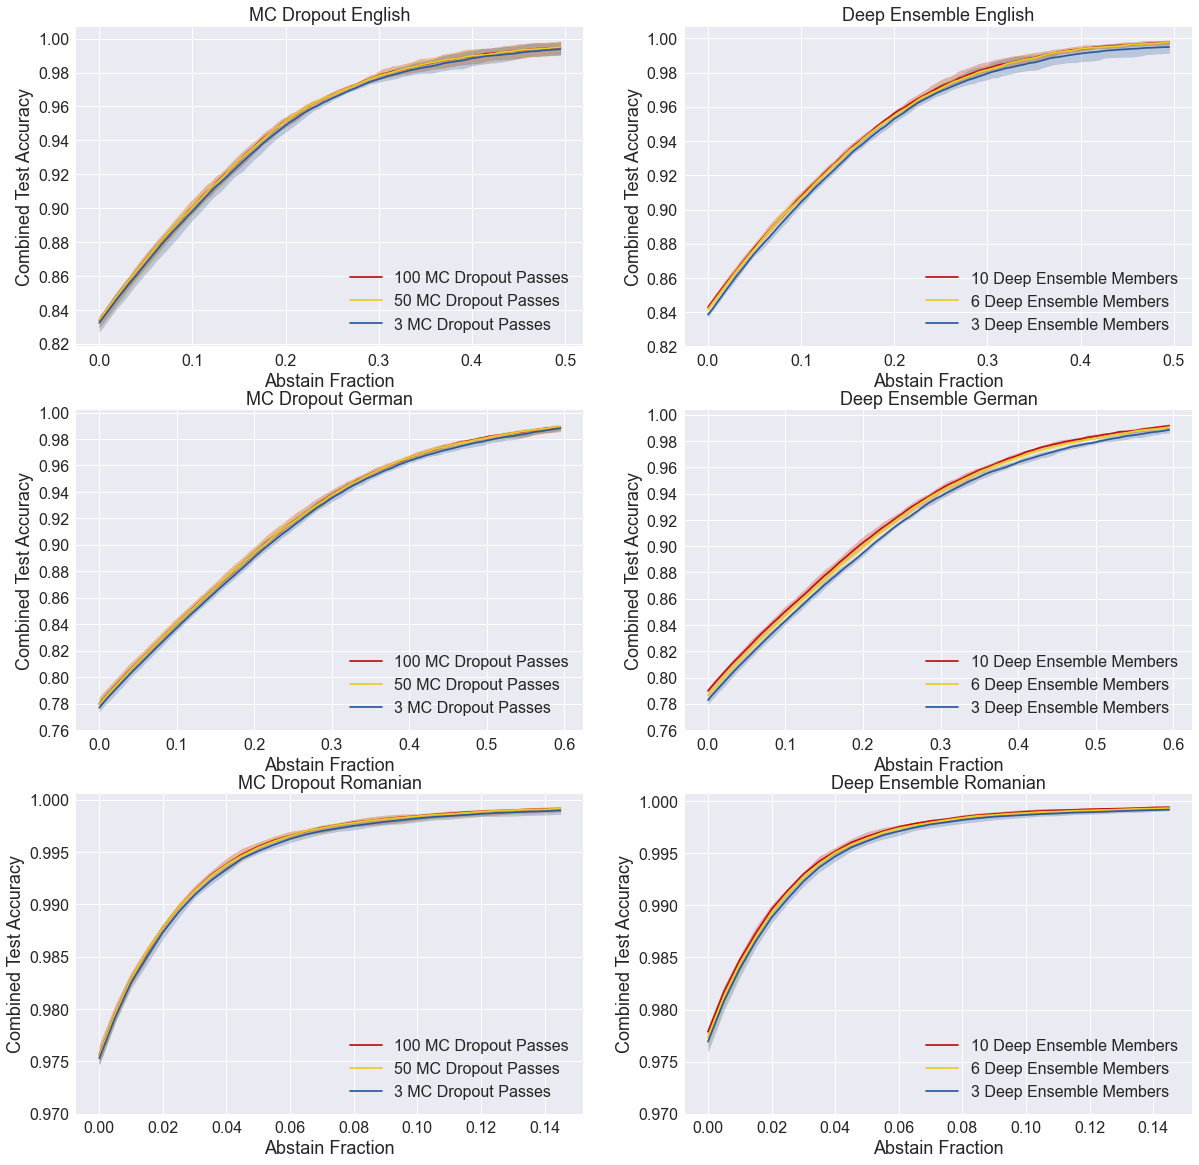

In [759]:
create_accuracy_plot_ensembles_text(df_list, 100,plot_limit_german=120,plot_limit_romanian=30, in_domain=in_domain)

In [21]:
if in_domain:
    df_list_diff = [MCDropout_diff, DeepEnsemble_diff,MCDropout_german_diff, DeepEnsemble_german_diff,MCDropout_romanian_diff, DeepEnsemble_romanian_diff]
else:
    df_list_diff = [MCDropout_diff, DeepEnsemble_diff,MCDropout_german_diff, DeepEnsemble_german_diff]


In [24]:
def create_accuracy_plot_ensembles_text_diff(df_list,MCDropout, plot_limit,plot_limit_german,plot_limit_romanian, in_domain):
    
    MCDropout_diff_english_dict = defaultdict(dict)
    DeepEnsemble_diff_english_dict = defaultdict(dict)
    MCDropout_german_diff_dict = defaultdict(dict)
    DeepEnsemble_german_diff_dict = defaultdict(dict)
    MCDropout_romanian_diff_dict = defaultdict(dict)
    DeepEnsemble_romanian_diff_dict = defaultdict(dict)
    
    dicts = [MCDropout_diff_english_dict,DeepEnsemble_diff_english_dict,MCDropout_german_diff_dict,DeepEnsemble_german_diff_dict,MCDropout_romanian_diff_dict,DeepEnsemble_romanian_diff_dict]
    
    for x, j in enumerate(df_list):
        for i in j:
            dicts[x]["combined accuracy softmax"]["num ensembles:" + str(i["num_ensemble"].iloc[0])] = i["AbstainAccuracy_Softmax_CombinedAcc"]
            dicts[x]["min combined accuracy softmax"]["num ensembles:" + str(i["num_ensemble"].iloc[0])] = i["min_AbstainAccuracy_Softmax_CombinedAcc"]
            dicts[x]["max combined accuracy softmax"]["num ensembles:" + str(i["num_ensemble"].iloc[0])] = i["max_AbstainAccuracy_Softmax_CombinedAcc"]
     
    
    fraction_unlimited = MCDropout[0]['Abstain Fraction']
    fraction_limited = MCDropout[0]['Abstain Fraction'][:plot_limit]
    fraction_limited_german = MCDropout[0]['Abstain Fraction'][:plot_limit_german]
    fraction_limited_romanian = MCDropout[0]['Abstain Fraction'][:plot_limit_romanian]
    
    fig = plt.figure(figsize=(20, 20))
    fig.tight_layout()
    
    
    
    plt.subplot(3, 2, 1)
    plt.plot(fraction_limited, MCDropout_diff_english_dict["combined accuracy softmax"]["num ensembles:100"][:plot_limit], color=colors[0], label="100 Passes")
    #plt.fill_between(fraction_limited,MCDropout_diff_english_dict["min combined accuracy softmax"]["num ensembles:100"][:plot_limit],MCDropout_diff_english_dict["max combined accuracy softmax"]["num ensembles:100"][:plot_limit],color=colors[0],alpha=0.25)
    plt.plot(fraction_limited, MCDropout_diff_english_dict["combined accuracy softmax"]["num ensembles:80"][:plot_limit], color=colors[1], label="80 Passes")
    #plt.fill_between(fraction_limited,MCDropout_diff_english_dict["min combined accuracy softmax"]["num ensembles:80"][:plot_limit],MCDropout_diff_english_dict["max combined accuracy softmax"]["num ensembles:80"][:plot_limit],color=colors[1],alpha=0.25)
    plt.plot(fraction_limited, MCDropout_diff_english_dict["combined accuracy softmax"]["num ensembles:60"][:plot_limit], color=colors[2], label="60 Passes")
    #plt.fill_between(fraction_limited,MCDropout_diff_english_dict["min combined accuracy softmax"]["num ensembles:60"][:plot_limit],MCDropout_diff_english_dict["max combined accuracy softmax"]["num ensembles:60"][:plot_limit],color=colors[2],alpha=0.25)
    plt.plot(fraction_limited, MCDropout_diff_english_dict["combined accuracy softmax"]["num ensembles:40"][:plot_limit], color=colors[3], label="40 Passes")
    #plt.fill_between(fraction_limited,MCDropout_diff_english_dict["min combined accuracy softmax"]["num ensembles:40"][:plot_limit],MCDropout_diff_english_dict["max combined accuracy softmax"]["num ensembles:40"][:plot_limit],color=colors[3],alpha=0.25)
    plt.plot(fraction_limited, MCDropout_diff_english_dict["combined accuracy softmax"]["num ensembles:20"][:plot_limit], color=colors[4], label="20 Passes")
    #plt.fill_between(fraction_limited,MCDropout_diff_english_dict["min combined accuracy softmax"]["num ensembles:20"][:plot_limit],MCDropout_diff_english_dict["max combined accuracy softmax"]["num ensembles:20"][:plot_limit],color=colors[4],alpha=0.25)
    plt.plot(fraction_limited, MCDropout_diff_english_dict["combined accuracy softmax"]["num ensembles:10"][:plot_limit], color=colors[5], label="10 Passes")
    #plt.fill_between(fraction_limited,MCDropout_diff_english_dict["min combined accuracy softmax"]["num ensembles:10"][:plot_limit],MCDropout_diff_english_dict["max combined accuracy softmax"]["num ensembles:10"][:plot_limit],color=colors[5],alpha=0.25)
    plt.plot(fraction_limited, MCDropout_diff_english_dict["combined accuracy softmax"]["num ensembles:3"][:plot_limit], color="grey", label="3 Passes")
    #plt.fill_between(fraction_limited,MCDropout_diff_english_dict["min combined accuracy softmax"]["num ensembles:3"][:plot_limit],MCDropout_diff_english_dict["max combined accuracy softmax"]["num ensembles:3"][:plot_limit],color="grey",alpha=0.25)
    plt.title("MC Dropout English")
    #plt.yticks(np.arange(0.82,1.019,step=0.02))
    #plt.ylabel('Difference in Combined Test Accuracy to Baseline')
    #plt.legend(loc='upper right')
    
    
    plt.subplot(3, 2, 3)
    plt.plot(fraction_limited_german, MCDropout_german_diff_dict["combined accuracy softmax"]["num ensembles:100"][:plot_limit_german], color=colors[0], label="100 Passes")
    #plt.fill_between(fraction_limited_german,MCDropout_german_diff_dict["min combined accuracy softmax"]["num ensembles:100"][:plot_limit_german],MCDropout_german_diff_dict["max combined accuracy softmax"]["num ensembles:100"][:plot_limit_german],color=colors[0],alpha=0.25)
    plt.plot(fraction_limited_german, MCDropout_german_diff_dict["combined accuracy softmax"]["num ensembles:80"][:plot_limit_german], color=colors[1], label="80 Passes")
    plt.plot(fraction_limited_german, MCDropout_german_diff_dict["combined accuracy softmax"]["num ensembles:60"][:plot_limit_german], color=colors[2], label="60 Passes")
    plt.plot(fraction_limited_german, MCDropout_german_diff_dict["combined accuracy softmax"]["num ensembles:40"][:plot_limit_german], color=colors[3], label="40 Passes")
    plt.plot(fraction_limited_german, MCDropout_german_diff_dict["combined accuracy softmax"]["num ensembles:20"][:plot_limit_german], color=colors[4], label="20 Passes")
    #plt.fill_between(fraction_limited_german,MCDropout_german_diff_dict["min combined accuracy softmax"]["num ensembles:50"][:plot_limit_german],MCDropout_german_diff_dict["max combined accuracy softmax"]["num ensembles:50"][:plot_limit_german],color=colors[1],alpha=0.25)
    plt.plot(fraction_limited_german, MCDropout_german_diff_dict["combined accuracy softmax"]["num ensembles:10"][:plot_limit_german], color=colors[5], label="10 Passes")
    plt.plot(fraction_limited_german, MCDropout_german_diff_dict["combined accuracy softmax"]["num ensembles:3"][:plot_limit_german], color="grey", label="3 Passes")
    #plt.fill_between(fraction_limited_german,MCDropout_german_diff_dict["min combined accuracy softmax"]["num ensembles:3"][:plot_limit_german],MCDropout_german_diff_dict["max combined accuracy softmax"]["num ensembles:3"][:plot_limit_german],color=colors[2],alpha=0.25)
    plt.title("MC Dropout German")
    #plt.yticks(np.arange(0.76,1.019,step=0.02))
    #plt.ylabel('Difference in Combined Test Accuracy to Baseline')
    #plt.legend(loc='upper right')
    
    
    plt.subplot(3, 2, 2)
    plt.plot(fraction_limited, DeepEnsemble_diff_english_dict["combined accuracy softmax"]["num ensembles:10"][:plot_limit], color=colors[0], label="10 Members")
    #plt.fill_between(fraction_limited,DeepEnsemble_diff_english_dict["min combined accuracy softmax"]["num ensembles:10"][:plot_limit],DeepEnsemble_diff_english_dict["max combined accuracy softmax"]["num ensembles:10"][:plot_limit],color=colors[0],alpha=0.25)
    plt.plot(fraction_limited, DeepEnsemble_diff_english_dict["combined accuracy softmax"]["num ensembles:8"][:plot_limit], color=colors[1], label="8 Members")
    plt.plot(fraction_limited, DeepEnsemble_diff_english_dict["combined accuracy softmax"]["num ensembles:6"][:plot_limit], color=colors[2], label="6 Members")
    plt.plot(fraction_limited, DeepEnsemble_diff_english_dict["combined accuracy softmax"]["num ensembles:4"][:plot_limit], color=colors[3], label="4 Members")
    #plt.fill_between(fraction_limited,DeepEnsemble_diff_english_dict["min combined accuracy softmax"]["num ensembles:6"][:plot_limit],DeepEnsemble_diff_english_dict["max combined accuracy softmax"]["num ensembles:6"][:plot_limit],color=colors[1],alpha=0.25)
    plt.plot(fraction_limited, DeepEnsemble_diff_english_dict["combined accuracy softmax"]["num ensembles:3"][:plot_limit], color="grey", label="3 Members")
    #plt.fill_between(fraction_limited,DeepEnsemble_diff_english_dict["min combined accuracy softmax"]["num ensembles:3"][:plot_limit],DeepEnsemble_diff_english_dict["max combined accuracy softmax"]["num ensembles:3"][:plot_limit],color=colors[2],alpha=0.25)
    plt.title("Deep Ensemble English")
    #plt.yticks(np.arange(0.82,1.019,step=0.02))
    #plt.ylabel('Difference in Combined Test Accuracy to Baseline')
    #plt.ylabel('Test Accuracy')
    #plt.legend(loc='upper right')
    
    
    plt.subplot(3, 2, 4)
    plt.plot(fraction_limited_german, DeepEnsemble_german_diff_dict["combined accuracy softmax"]["num ensembles:10"][:plot_limit_german], color=colors[0], label="10 Members")
    #plt.fill_between(fraction_limited_german,DeepEnsemble_german_diff_dict["min combined accuracy softmax"]["num ensembles:10"][:plot_limit_german],DeepEnsemble_german_diff_dict["max combined accuracy softmax"]["num ensembles:10"][:plot_limit_german],color=colors[0],alpha=0.25)
    plt.plot(fraction_limited_german, DeepEnsemble_german_diff_dict["combined accuracy softmax"]["num ensembles:8"][:plot_limit_german], color=colors[1], label="8 Members")
    plt.plot(fraction_limited_german, DeepEnsemble_german_diff_dict["combined accuracy softmax"]["num ensembles:6"][:plot_limit_german], color=colors[2], label="6 Members")
    plt.plot(fraction_limited_german, DeepEnsemble_german_diff_dict["combined accuracy softmax"]["num ensembles:4"][:plot_limit_german], color=colors[3], label="4 Members")
    #plt.fill_between(fraction_limited_german,DeepEnsemble_german_diff_dict["min combined accuracy softmax"]["num ensembles:6"][:plot_limit_german],DeepEnsemble_german_diff_dict["max combined accuracy softmax"]["num ensembles:6"][:plot_limit_german],color=colors[1],alpha=0.25)
    #plt.plot(fraction_limited_german, DeepEnsemble_diff_english_dict["combined accuracy softmax"]["num ensembles:4"][:plot_limit], color=colors[4], label="4")
    plt.plot(fraction_limited_german, DeepEnsemble_german_diff_dict["combined accuracy softmax"]["num ensembles:3"][:plot_limit_german], color="grey", label="3 Members")
    #plt.fill_between(fraction_limited_german,DeepEnsemble_german_diff_dict["min combined accuracy softmax"]["num ensembles:3"][:plot_limit_german],DeepEnsemble_german_diff_dict["max combined accuracy softmax"]["num ensembles:3"][:plot_limit_german],color=colors[2],alpha=0.25)
    plt.title("Deep Ensemble German")
    #plt.yticks(np.arange(0.76,1.019,step=0.02))
    #plt.ylabel('Difference in Combined Test Accuracy to Baseline')
    #plt.ylabel('Test Accuracy')
    #plt.legend(loc='upper right')
    
    
    if in_domain:
        plt.subplot(3, 2, 5)
        plt.plot(fraction_limited_romanian, MCDropout_romanian_diff_dict["combined accuracy softmax"]["num ensembles:100"][:plot_limit_romanian], color=colors[0], label="100 Passes")
        #plt.fill_between(fraction_limited_romanian,MCDropout_romanian_diff_dict["min combined accuracy softmax"]["num ensembles:100"][:plot_limit_romanian],MCDropout_romanian_diff_dict["max combined accuracy softmax"]["num ensembles:100"][:plot_limit_romanian],color=colors[0],alpha=0.25)
        plt.plot(fraction_limited_romanian, MCDropout_romanian_diff_dict["combined accuracy softmax"]["num ensembles:80"][:plot_limit_romanian], color=colors[1], label="80 Passes")
        plt.plot(fraction_limited_romanian, MCDropout_romanian_diff_dict["combined accuracy softmax"]["num ensembles:60"][:plot_limit_romanian], color=colors[2], label="60 Passes")
        plt.plot(fraction_limited_romanian, MCDropout_romanian_diff_dict["combined accuracy softmax"]["num ensembles:40"][:plot_limit_romanian], color=colors[3], label="40 Passes")
        plt.plot(fraction_limited_romanian, MCDropout_romanian_diff_dict["combined accuracy softmax"]["num ensembles:20"][:plot_limit_romanian], color=colors[4], label="20 Passes")
        #plt.fill_between(fraction_limited_romanian,MCDropout_romanian_diff_dict["min combined accuracy softmax"]["num ensembles:50"][:plot_limit_romanian],MCDropout_romanian_diff_dict["max combined accuracy softmax"]["num ensembles:50"][:plot_limit_romanian],color=colors[1],alpha=0.25)
        plt.plot(fraction_limited_romanian, MCDropout_romanian_diff_dict["combined accuracy softmax"]["num ensembles:10"][:plot_limit_romanian], color=colors[5], label="10 Passes")
        plt.plot(fraction_limited_romanian, MCDropout_romanian_diff_dict["combined accuracy softmax"]["num ensembles:3"][:plot_limit_romanian], color="grey", label="3 Passes")
        #plt.fill_between(fraction_limited_romanian,MCDropout_romanian_diff_dict["min combined accuracy softmax"]["num ensembles:3"][:plot_limit_romanian],MCDropout_romanian_diff_dict["max combined accuracy softmax"]["num ensembles:3"][:plot_limit_romanian],color=colors[2],alpha=0.25)
        plt.title("MC Dropout Romanian")
        #plt.yticks(np.arange(0.97,1.004,step=0.005))
        #plt.ylabel('Difference in Combined Test Accuracy to Baseline')
        #plt.xlabel("Abstain Fraction")
        #plt.legend(loc='upper right')


        plt.subplot(3, 2, 6)
        plt.plot(fraction_limited_romanian, DeepEnsemble_romanian_diff_dict["combined accuracy softmax"]["num ensembles:10"][:plot_limit_romanian], color=colors[0], label="10 Members")
        #plt.fill_between(fraction_limited_romanian,DeepEnsemble_romanian_diff_dict["min combined accuracy softmax"]["num ensembles:10"][:plot_limit_romanian],DeepEnsemble_romanian_diff_dict["max combined accuracy softmax"]["num ensembles:10"][:plot_limit_romanian],color=colors[0],alpha=0.25)
        plt.plot(fraction_limited_romanian, DeepEnsemble_romanian_diff_dict["combined accuracy softmax"]["num ensembles:8"][:plot_limit_romanian], color=colors[1], label="8 Members")
        plt.plot(fraction_limited_romanian, DeepEnsemble_romanian_diff_dict["combined accuracy softmax"]["num ensembles:6"][:plot_limit_romanian], color=colors[2], label="6 Members")
        plt.plot(fraction_limited_romanian, DeepEnsemble_romanian_diff_dict["combined accuracy softmax"]["num ensembles:4"][:plot_limit_romanian], color=colors[3], label="4 Members")
        #plt.fill_between(fraction_limited_romanian,DeepEnsemble_romanian_diff_dict["min combined accuracy softmax"]["num ensembles:6"][:plot_limit_romanian],DeepEnsemble_romanian_diff_dict["max combined accuracy softmax"]["num ensembles:6"][:plot_limit_romanian],color=colors[1],alpha=0.25)
        #plt.plot(fraction_limited_german, DeepEnsemble_diff_english_dict["combined accuracy softmax"]["num ensembles:4"][:plot_limit], color=colors[4], label="4")
        plt.plot(fraction_limited_romanian, DeepEnsemble_romanian_diff_dict["combined accuracy softmax"]["num ensembles:3"][:plot_limit_romanian], color="grey", label="3 Members")
        #plt.fill_between(fraction_limited_romanian,DeepEnsemble_romanian_diff_dict["min combined accuracy softmax"]["num ensembles:3"][:plot_limit_romanian],DeepEnsemble_romanian_diff_dict["max combined accuracy softmax"]["num ensembles:3"][:plot_limit_romanian],color=colors[2],alpha=0.25)
        #plt.ylabel('Difference in Combined Test Accuracy to Baseline')
        plt.title("Deep Ensemble Romanian")
        #plt.yticks(np.arange(0.97,1.004,step=0.005))

        #plt.xlabel("Abstain Fraction")
        #plt.ylabel('Test Accuracy')
        #plt.legend(loc='upper right')
        
    lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    #hand, labl = function_to_split(lines,labels,'&')

    #print(hand)
    
    print(labels)

    keep_indices = list(range(7))

    labels_ensemble = labels[14:19]
    labels = [labels[i] for i in keep_indices]

    
    
    if in_domain:
        fig.text(0.5, 0.09, 'Abstain Fraction', ha='center')
        fig.text(0.07, 0.5, 'Difference in Combined Test Accuracy to Baseline', va='center', rotation='vertical')

        fig.legend(labels, loc='lower left', bbox_to_anchor=(0.13,0.035), ncol=3, bbox_transform=fig.transFigure)
        fig.legend(lines[14:19],labels_ensemble, loc='lower left', bbox_to_anchor=(0.55,0.05), ncol=3, bbox_transform=fig.transFigure)
        
        fig.savefig('Number Ensemble Comparison Combined Difference Softmax.pdf')
    else:
        fig.text(0.5, 0.355, 'Abstain Fraction', ha='center')
        fig.text(0.07, 0.66, 'Difference in Combined Test Accuracy to Baseline', va='center', rotation='vertical')

        fig.legend(labels, loc='lower left', bbox_to_anchor=(0.13,0.3), ncol=3, bbox_transform=fig.transFigure)
        fig.legend(lines[14:19],labels_ensemble, loc='lower left', bbox_to_anchor=(0.55,0.315), ncol=3, bbox_transform=fig.transFigure)
        fig.savefig('Number Ensemble Comparison Combined Difference Softmax OOD.pdf')

['100 Passes', '80 Passes', '60 Passes', '40 Passes', '20 Passes', '10 Passes', '3 Passes', '100 Passes', '80 Passes', '60 Passes', '40 Passes', '20 Passes', '10 Passes', '3 Passes', '10 Members', '8 Members', '6 Members', '4 Members', '3 Members', '10 Members', '8 Members', '6 Members', '4 Members', '3 Members']


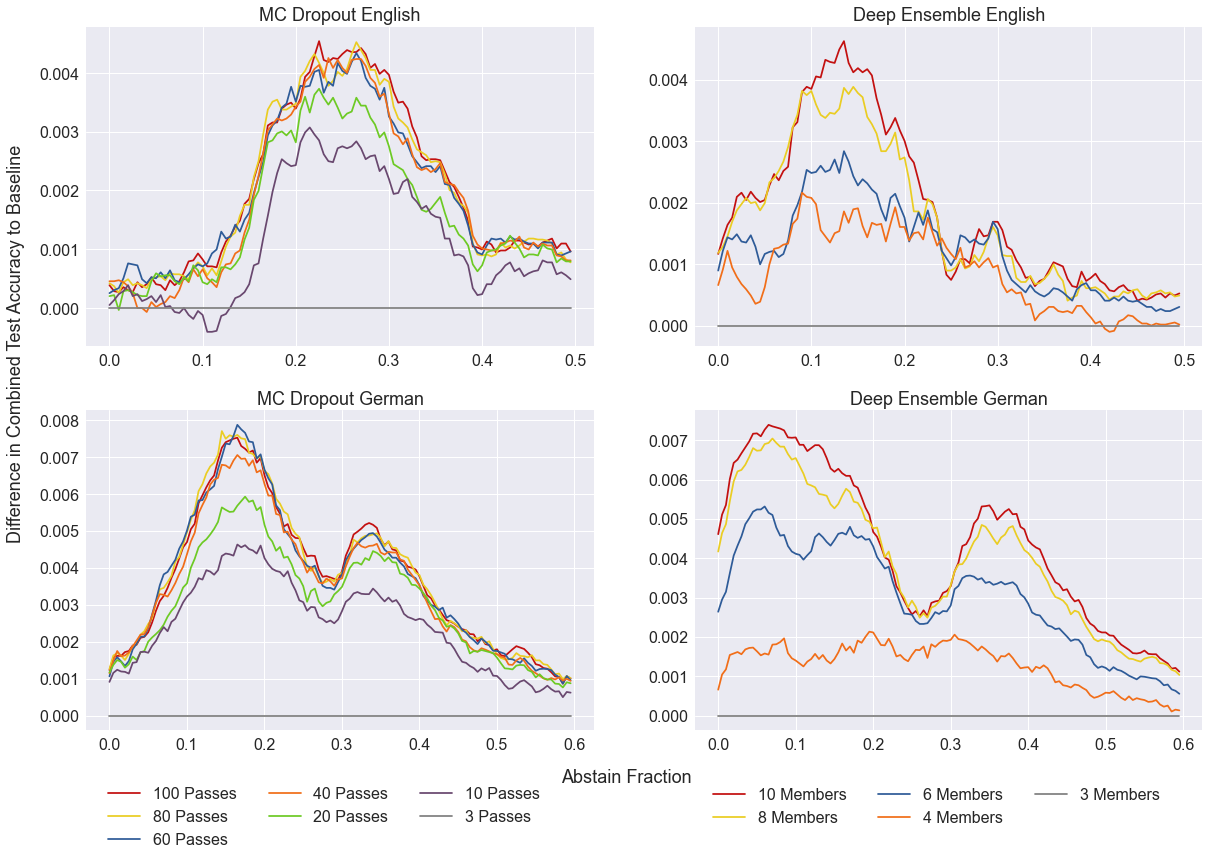

In [25]:
create_accuracy_plot_ensembles_text_diff(df_list_diff, MCDropout,100,plot_limit_german=120,plot_limit_romanian=30, in_domain=in_domain)

## value

In [26]:
for i,x in enumerate(MCDropout_diff):
    x["value"] = x["AbstainAccuracy_Softmax_CombinedAcc"] * n_samples  * time_cost_rework/60 * hourly_wage + dropout_runtime_list[i]/60 * (-cost_runtime)/60

for i,x in enumerate(DeepEnsemble_diff):
    x["value"] = x["AbstainAccuracy_Softmax_CombinedAcc"] * n_samples * time_cost_rework/60 * hourly_wage + ensemble_runtime_list[i]/60 * (-cost_runtime)/60
    

In [27]:
for i,x in enumerate(MCDropout_german_diff):
    x["value"] = x["AbstainAccuracy_Softmax_CombinedAcc"] * n_samples_german * time_cost_rework/60 * hourly_wage +  dropout_runtime_list_german[i]/60 * (-cost_runtime)/60

for i,x in enumerate(DeepEnsemble_german_diff):
    x["value"] = x["AbstainAccuracy_Softmax_CombinedAcc"] * n_samples_german  * time_cost_rework/60 * hourly_wage + ensemble_runtime_list_german[i]/60 * (-cost_runtime)/60

In [28]:
if in_domain:
    for i,x in enumerate(MCDropout_romanian_diff):
        x["value"] = x["AbstainAccuracy_Softmax_CombinedAcc"] * n_samples_romanian  * time_cost_rework/60 * hourly_wage +dropout_runtime_list_romanian[i]/60 * (-cost_runtime)/60

    for i,x in enumerate(DeepEnsemble_romanian_diff):
        x["value"] = x["AbstainAccuracy_Softmax_CombinedAcc"] * n_samples_romanian  * time_cost_rework/60 * hourly_wage +ensemble_runtime_list_romanian[i]/60 * (-cost_runtime)/60

In [29]:
if in_domain:
    df_list_diff_value= [MCDropout_diff, DeepEnsemble_diff,MCDropout_german_diff, DeepEnsemble_german_diff,MCDropout_romanian_diff, DeepEnsemble_romanian_diff]
else:
    df_list_diff_value= [MCDropout_diff, DeepEnsemble_diff,MCDropout_german_diff, DeepEnsemble_german_diff]


In [767]:
def create_accuracy_plot_ensembles_value(df_list_diff_value,MCDropout, plot_limit,plot_limit_german,plot_limit_romanian, in_domain):
    
    MCDropout_english_diff_dict = defaultdict(dict)
    DeepEnsemble_english_diff_dict = defaultdict(dict)
    MCDropout_german_diff_dict = defaultdict(dict)
    DeepEnsemble_german_diff_dict = defaultdict(dict)
    MCDropout_romanian_diff_dict = defaultdict(dict)
    MCDropout_romanian_diff_dict = defaultdict(dict)
    
    dicts = [MCDropout_english_diff_dict,DeepEnsemble_english_diff_dict,MCDropout_german_diff_dict,DeepEnsemble_german_diff_dict,MCDropout_romanian_diff_dict,MCDropout_romanian_diff_dict]
    
    for x, j in enumerate(df_list_diff_value):
        for i in j:
            #MCDropout_english_diff_dict["model accuracy softmax"]["num ensembles:" + str(i["num_ensemble"].iloc[0])] = i["AbstainAccuracy_Softmax_Acc"]
            dicts[x]["value"]["num ensembles:" + str(i["num_ensemble"].iloc[0])] = i["value"]

    fraction_unlimited = MCDropout[0]['Abstain Fraction']
    fraction_limited = MCDropout[0]['Abstain Fraction'][:plot_limit]
    
    fig = plt.figure(figsize=(20, 20))
    fig.tight_layout()
    
    
    
    plt.subplot(3, 2, 1)
    plt.plot(fraction_limited, MCDropout_english_diff_dict["value"]["num ensembles:100"][:plot_limit], color=colors[0], label="100 Passes")
    plt.plot(fraction_limited, MCDropout_english_diff_dict["value"]["num ensembles:80"][:plot_limit], color=colors[1], label="80 Passes")
    plt.plot(fraction_limited, MCDropout_english_diff_dict["value"]["num ensembles:60"][:plot_limit], color=colors[2], label="60 Passes")
    plt.plot(fraction_limited, MCDropout_english_diff_dict["value"]["num ensembles:40"][:plot_limit], color=colors[3], label="40 Passes")
    plt.plot(fraction_limited, MCDropout_english_diff_dict["value"]["num ensembles:20"][:plot_limit], color=colors[4], label="20 Passes")
    plt.plot(fraction_limited, MCDropout_english_diff_dict["value"]["num ensembles:10"][:plot_limit], color=colors[5], label="10 Passes")
    plt.plot(fraction_limited, MCDropout_english_diff_dict["value"]["num ensembles:3"][:plot_limit], color="grey", label="3 Passes")
    plt.title("MC Dropout English")
    #plt.ylabel('Value Above Baseline (in €)')
    #plt.legend(loc='upper right')
    
    
    plt.subplot(3, 2, 2)
    plt.plot(fraction_limited, DeepEnsemble_english_diff_dict["value"]["num ensembles:10"][:plot_limit], color=colors[0], label="10 Members")
    plt.plot(fraction_limited, DeepEnsemble_english_diff_dict["value"]["num ensembles:8"][:plot_limit], color=colors[1], label="8 Members")
    plt.plot(fraction_limited, DeepEnsemble_english_diff_dict["value"]["num ensembles:6"][:plot_limit], color=colors[2], label="6 Members")
    plt.plot(fraction_limited, DeepEnsemble_english_diff_dict["value"]["num ensembles:4"][:plot_limit], color=colors[3], label="4 Members")
    plt.plot(fraction_limited, DeepEnsemble_english_diff_dict["value"]["num ensembles:3"][:plot_limit], color="grey", label="3 Members")
    plt.title("Deep Ensemble English")
    #plt.legend(loc='upper right')
    
    
    plt.subplot(3, 2, 3)
    plt.plot(fraction_limited, MCDropout_german_diff_dict["value"]["num ensembles:100"][:plot_limit], color=colors[0], label="100 Passes")
    plt.plot(fraction_limited, MCDropout_german_diff_dict["value"]["num ensembles:80"][:plot_limit], color=colors[1], label="80 Passes")
    plt.plot(fraction_limited, MCDropout_german_diff_dict["value"]["num ensembles:60"][:plot_limit], color=colors[2], label="60 Passes")
    plt.plot(fraction_limited, MCDropout_german_diff_dict["value"]["num ensembles:40"][:plot_limit], color=colors[3], label="40 Passes")
    plt.plot(fraction_limited, MCDropout_german_diff_dict["value"]["num ensembles:20"][:plot_limit], color=colors[4], label="20 Passes")
    plt.plot(fraction_limited, MCDropout_german_diff_dict["value"]["num ensembles:10"][:plot_limit], color=colors[5], label="10 Passes")
    plt.plot(fraction_limited, MCDropout_german_diff_dict["value"]["num ensembles:3"][:plot_limit], color="grey", label="3 Passes")
    
    plt.title("MC Dropout German")
    #plt.ylabel('Value Above Baseline (in €)')
    #plt.legend(loc='upper right')
    
    
    plt.subplot(3, 2, 4)
    plt.plot(fraction_limited, DeepEnsemble_german_diff_dict["value"]["num ensembles:10"][:plot_limit], color=colors[0], label="10 Members")
    plt.plot(fraction_limited, DeepEnsemble_german_diff_dict["value"]["num ensembles:8"][:plot_limit], color=colors[1], label="8 Members")
    plt.plot(fraction_limited, DeepEnsemble_german_diff_dict["value"]["num ensembles:6"][:plot_limit], color=colors[2], label="6 Members")
    plt.plot(fraction_limited, DeepEnsemble_german_diff_dict["value"]["num ensembles:4"][:plot_limit], color=colors[3], label="4 Members")
    plt.plot(fraction_limited, DeepEnsemble_german_diff_dict["value"]["num ensembles:3"][:plot_limit], color="grey", label="3 Members")

    plt.title("Deep Ensemble German")
    #plt.legend(loc='upper right')
    
    if in_domain:
        plt.subplot(3, 2, 5)
        plt.plot(fraction_limited, MCDropout_romanian_diff_dict["value"]["num ensembles:100"][:plot_limit], color=colors[0], label="100 Passes")
        plt.plot(fraction_limited, MCDropout_romanian_diff_dict["value"]["num ensembles:80"][:plot_limit], color=colors[1], label="80 Passes")
        plt.plot(fraction_limited, MCDropout_romanian_diff_dict["value"]["num ensembles:60"][:plot_limit], color=colors[2], label="60 Passes")
        plt.plot(fraction_limited, MCDropout_romanian_diff_dict["value"]["num ensembles:40"][:plot_limit], color=colors[3], label="40 Passes")
        plt.plot(fraction_limited, MCDropout_romanian_diff_dict["value"]["num ensembles:20"][:plot_limit], color=colors[4], label="20 Passes")
        plt.plot(fraction_limited, MCDropout_romanian_diff_dict["value"]["num ensembles:10"][:plot_limit], color=colors[5], label="10 Passes")
        plt.plot(fraction_limited, MCDropout_romanian_diff_dict["value"]["num ensembles:3"][:plot_limit], color="grey", label="3 Passes")

        plt.title("MC Dropout Romanian")
        #plt.ylabel('Value Above Baseline (in €)')
        #plt.xlabel("Abstain Fraction")
        #plt.legend(loc='upper right')


        plt.subplot(3, 2, 6)
        plt.plot(fraction_limited, MCDropout_romanian_diff_dict["value"]["num ensembles:10"][:plot_limit], color=colors[0], label="10 Members")
        plt.plot(fraction_limited, MCDropout_romanian_diff_dict["value"]["num ensembles:8"][:plot_limit], color=colors[1], label="8 Members")
        plt.plot(fraction_limited, MCDropout_romanian_diff_dict["value"]["num ensembles:6"][:plot_limit], color=colors[2], label="6 Members")
        plt.plot(fraction_limited, MCDropout_romanian_diff_dict["value"]["num ensembles:4"][:plot_limit], color=colors[3], label="4 Members")
        plt.plot(fraction_limited, MCDropout_romanian_diff_dict["value"]["num ensembles:3"][:plot_limit], color="grey", label="3 Members")

        plt.title("Deep Ensemble Romanian")
        #plt.xlabel("Abstain Fraction")
        #plt.legend(loc='upper right')
        
    lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    #hand, labl = function_to_split(lines,labels,'&')

    #print(hand)
    
    print(labels)

    keep_indices = list(range(7))

    labels_ensemble = labels[7:12]
    labels = [labels[i] for i in keep_indices]

    
    
    if in_domain:
        fig.text(0.5, 0.09, 'Abstain Fraction', ha='center')
        fig.text(0.09, 0.5, 'Value Above Baseline (in €)', va='center', rotation='vertical')

        fig.legend(labels, loc='lower left', bbox_to_anchor=(0.13,0.035), ncol=3, bbox_transform=fig.transFigure)
        fig.legend(lines[7:12],labels_ensemble, loc='lower left', bbox_to_anchor=(0.55,0.05), ncol=3, bbox_transform=fig.transFigure)
        
        fig.savefig('Value Number Ensembles.pdf')
    else:
        fig.text(0.5, 0.355, 'Abstain Fraction', ha='center')
        fig.text(0.085, 0.66, 'Value Above Baseline (in €)', va='center', rotation='vertical')

        fig.legend(labels, loc='lower left', bbox_to_anchor=(0.13,0.3), ncol=3, bbox_transform=fig.transFigure)
        fig.legend(lines[7:12],labels_ensemble, loc='lower left', bbox_to_anchor=(0.55,0.315), ncol=3, bbox_transform=fig.transFigure)
        fig.savefig('Value Number Ensembles OOD.pdf')

    
    #fig.savefig('Value Number Ensembles.pdf')

['100 Passes', '80 Passes', '60 Passes', '40 Passes', '20 Passes', '10 Passes', '3 Passes', '10 Members', '8 Members', '6 Members', '4 Members', '3 Members', '100 Passes', '80 Passes', '60 Passes', '40 Passes', '20 Passes', '10 Passes', '3 Passes', '10 Members', '8 Members', '6 Members', '4 Members', '3 Members', '100 Passes', '80 Passes', '60 Passes', '40 Passes', '20 Passes', '10 Passes', '3 Passes', '10 Members', '8 Members', '6 Members', '4 Members', '3 Members']


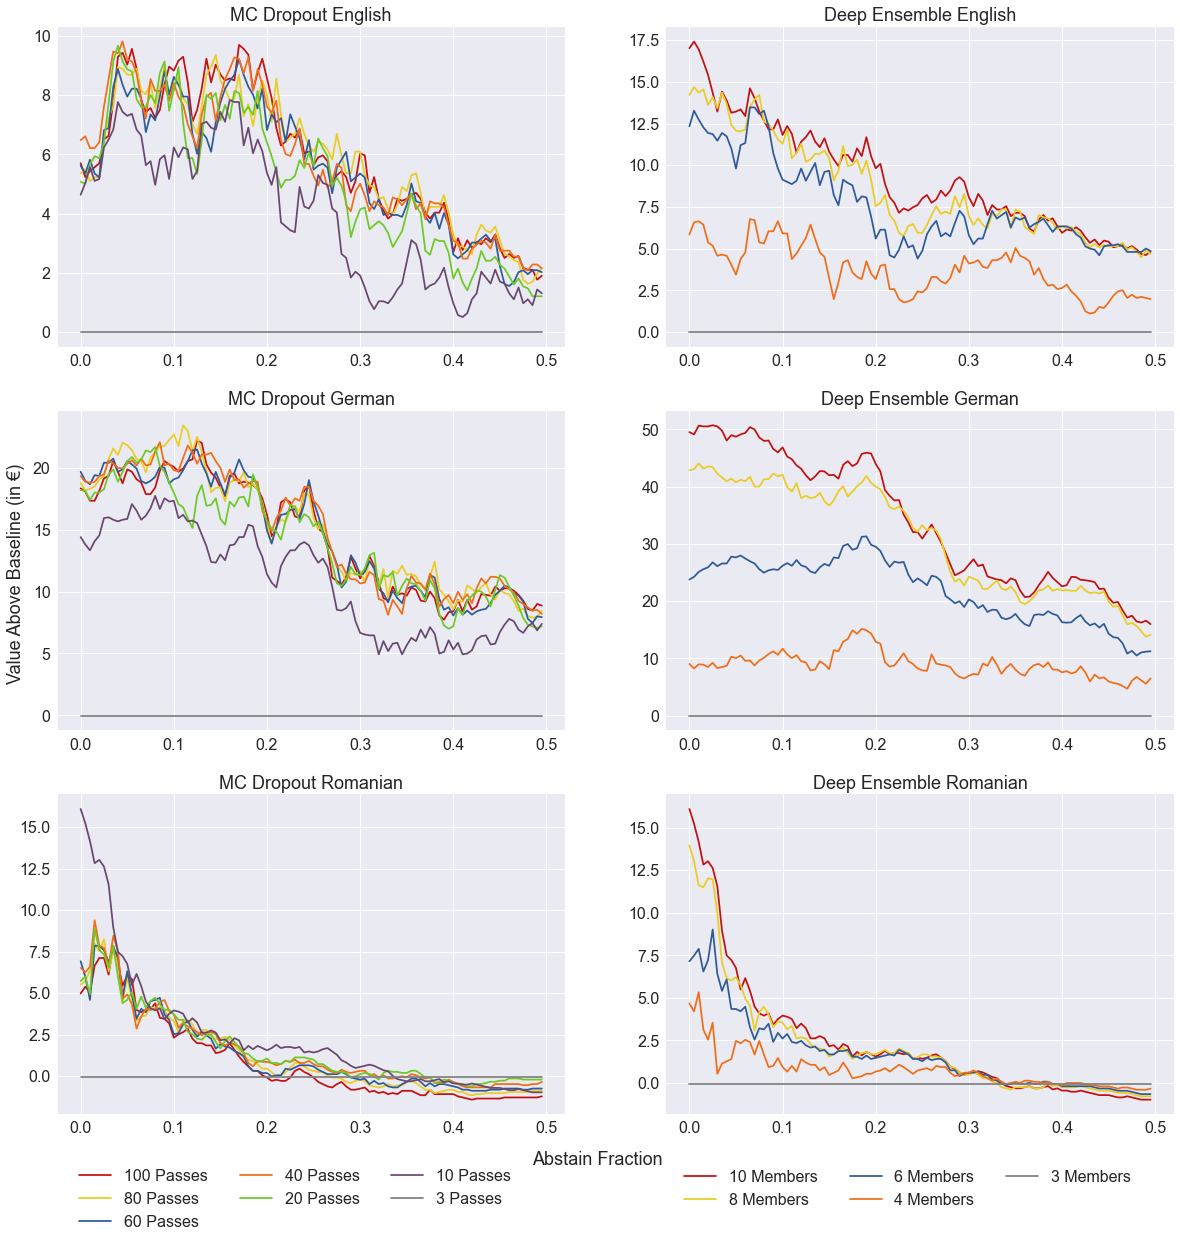

In [768]:
create_accuracy_plot_ensembles_value(df_list_diff_value, MCDropout,100,plot_limit_german=120,plot_limit_romanian=30, in_domain=in_domain)

# Confidence Score

In [30]:
def create_accuracy_plot_activation_functions(df_list, plot_limit,plot_limit_german,plot_limit_romanian,in_domain):
    
    MCDropout_english_dict = defaultdict(dict)
    DeepEnsemble_english_dict = defaultdict(dict)
    MCDropout_german_dict = defaultdict(dict)
    DeepEnsemble_german_dict = defaultdict(dict)
    MCDropout_romanian_dict = defaultdict(dict)
    DeepEnsemble_romanian_dict = defaultdict(dict)
    
    dicts = [MCDropout_english_dict,DeepEnsemble_english_dict,MCDropout_german_dict,DeepEnsemble_german_dict,MCDropout_romanian_dict,DeepEnsemble_romanian_dict]
    
    for x, j in enumerate(df_list):
        for i in j:
            dicts[x]["combined accuracy softmax"]["num ensembles:" + str(i["num_ensemble"].iloc[0])] = i["AbstainAccuracy_Softmax_CombinedAcc"]
            dicts[x]["min combined accuracy softmax"]["num ensembles:" + str(i["num_ensemble"].iloc[0])] = i["min_AbstainAccuracy_Softmax_CombinedAcc"]
            dicts[x]["max combined accuracy softmax"]["num ensembles:" + str(i["num_ensemble"].iloc[0])] = i["max_AbstainAccuracy_Softmax_CombinedAcc"]

            dicts[x]["combined accuracy variance"]["num ensembles:" + str(i["num_ensemble"].iloc[0])] = i["AbstainAccuracy_Variance_CombinedAcc"]
            dicts[x]["min combined accuracy variance"]["num ensembles:" + str(i["num_ensemble"].iloc[0])] = i["min_AbstainAccuracy_Variance_CombinedAcc"]
            dicts[x]["max combined accuracy variance"]["num ensembles:" + str(i["num_ensemble"].iloc[0])] = i["max_AbstainAccuracy_Variance_CombinedAcc"]

            dicts[x]["combined accuracy bald"]["num ensembles:" + str(i["num_ensemble"].iloc[0])] = i["AbstainAccuracy_BALD_CombinedAcc"]
            dicts[x]["min combined accuracy bald"]["num ensembles:" + str(i["num_ensemble"].iloc[0])] = i["min_AbstainAccuracy_BALD_CombinedAcc"]
            dicts[x]["max combined accuracy bald"]["num ensembles:" + str(i["num_ensemble"].iloc[0])] = i["max_AbstainAccuracy_BALD_CombinedAcc"]

    fraction_unlimited = df_list[0][0]['Abstain Fraction']
    fraction_limited = df_list[0][0]['Abstain Fraction'][:plot_limit]
    fraction_limited_german = df_list[0][0]['Abstain Fraction'][:plot_limit_german]
    fraction_limited_romanian = df_list[0][0]['Abstain Fraction'][:plot_limit_romanian]
    
    fig = plt.figure(figsize=(20, 20))
    fig.tight_layout()
    
    

    plt.subplot(3, 2, 1)
    plt.plot(fraction_limited, MCDropout_english_dict["combined accuracy softmax"]["num ensembles:100"][:plot_limit], color=colors[0], label="Softmax")
    plt.fill_between(fraction_limited,MCDropout_english_dict["min combined accuracy softmax"]["num ensembles:100"][:plot_limit],MCDropout_english_dict["max combined accuracy softmax"]["num ensembles:100"][:plot_limit],color=colors[0],alpha=0.25)
    plt.plot(fraction_limited, MCDropout_english_dict["combined accuracy variance"]["num ensembles:100"][:plot_limit], color=colors[1], label="Variance")
    plt.fill_between(fraction_limited,MCDropout_english_dict["min combined accuracy variance"]["num ensembles:100"][:plot_limit],MCDropout_english_dict["max combined accuracy variance"]["num ensembles:100"][:plot_limit],color=colors[1],alpha=0.25)
    plt.plot(fraction_limited, MCDropout_english_dict["combined accuracy bald"]["num ensembles:100"][:plot_limit], color=colors[2], label="BALD")
    plt.fill_between(fraction_limited,MCDropout_english_dict["min combined accuracy bald"]["num ensembles:100"][:plot_limit],MCDropout_english_dict["max combined accuracy bald"]["num ensembles:100"][:plot_limit],color=colors[2],alpha=0.25)
    plt.title("MC Dropout English")
    if in_domain:
        plt.yticks(np.arange(0.82,1.019,step=0.02))
    else:
        plt.yticks(np.arange(0.78,1.019,step=0.02))
    #plt.ylabel('Combined Test Accuracy')
    #plt.xlabel('Abstain Fraction')

    plt.subplot(3, 2, 3)
    plt.plot(fraction_limited_german, MCDropout_german_dict["combined accuracy softmax"]["num ensembles:100"][:plot_limit_german], color=colors[0], label="Softmax")
    plt.fill_between(fraction_limited_german,MCDropout_german_dict["min combined accuracy softmax"]["num ensembles:100"][:plot_limit_german],MCDropout_german_dict["max combined accuracy softmax"]["num ensembles:100"][:plot_limit_german],color=colors[0],alpha=0.25)
    plt.plot(fraction_limited_german, MCDropout_german_dict["combined accuracy variance"]["num ensembles:100"][:plot_limit_german], color=colors[1], label="Variance")
    plt.fill_between(fraction_limited_german,MCDropout_german_dict["min combined accuracy variance"]["num ensembles:100"][:plot_limit_german],MCDropout_german_dict["max combined accuracy variance"]["num ensembles:100"][:plot_limit_german],color=colors[1],alpha=0.25)
    plt.plot(fraction_limited_german, MCDropout_german_dict["combined accuracy bald"]["num ensembles:100"][:plot_limit_german], color=colors[2], label="BALD")
    plt.fill_between(fraction_limited_german,MCDropout_german_dict["min combined accuracy bald"]["num ensembles:100"][:plot_limit_german],MCDropout_german_dict["max combined accuracy bald"]["num ensembles:100"][:plot_limit_german],color=colors[2],alpha=0.25)
    plt.title("MC Dropout German")
    if in_domain:
        plt.yticks(np.arange(0.78,1.019,step=0.02))
    else:
        plt.yticks(np.arange(0.76,1.019,step=0.02))
    #plt.ylabel('Combined Test Accuracy')
    #plt.xlabel('Abstain Fraction')
    #plt.legend(loc='lower right')
    
    
    
    plt.subplot(3, 2, 2)
    plt.plot(fraction_limited, DeepEnsemble_english_dict["combined accuracy softmax"]["num ensembles:10"][:plot_limit], color=colors[0], label="Softmax")
    plt.fill_between(fraction_limited,DeepEnsemble_english_dict["min combined accuracy softmax"]["num ensembles:10"][:plot_limit],DeepEnsemble_english_dict["max combined accuracy softmax"]["num ensembles:10"][:plot_limit],color=colors[0],alpha=0.25)
    plt.plot(fraction_limited, DeepEnsemble_english_dict["combined accuracy variance"]["num ensembles:10"][:plot_limit], color=colors[1], label="Variance")
    plt.fill_between(fraction_limited,DeepEnsemble_english_dict["min combined accuracy variance"]["num ensembles:10"][:plot_limit],DeepEnsemble_english_dict["max combined accuracy variance"]["num ensembles:10"][:plot_limit],color=colors[1],alpha=0.25)
    plt.plot(fraction_limited, DeepEnsemble_english_dict["combined accuracy bald"]["num ensembles:10"][:plot_limit], color=colors[2], label="BALD")
    plt.fill_between(fraction_limited,DeepEnsemble_english_dict["min combined accuracy bald"]["num ensembles:10"][:plot_limit],DeepEnsemble_english_dict["max combined accuracy bald"]["num ensembles:10"][:plot_limit],color=colors[2],alpha=0.25)
    plt.title("Deep Ensemble English")
    if in_domain:
        plt.yticks(np.arange(0.82,1.019,step=0.02))
    else:
        plt.yticks(np.arange(0.78,1.019,step=0.02))
    #plt.ylabel('Combined Test Accuracy')
    #plt.xlabel('Abstain Fraction')
    #plt.legend(loc='lower right')
    
    plt.subplot(3, 2, 4)
    plt.plot(fraction_limited_german, DeepEnsemble_german_dict["combined accuracy softmax"]["num ensembles:10"][:plot_limit_german], color=colors[0], label="Softmax")
    plt.fill_between(fraction_limited_german,DeepEnsemble_german_dict["min combined accuracy softmax"]["num ensembles:10"][:plot_limit_german],DeepEnsemble_german_dict["max combined accuracy softmax"]["num ensembles:10"][:plot_limit_german],color=colors[0],alpha=0.25)
    plt.plot(fraction_limited_german, DeepEnsemble_german_dict["combined accuracy variance"]["num ensembles:10"][:plot_limit_german], color=colors[1], label="Variance")
    plt.fill_between(fraction_limited_german,DeepEnsemble_german_dict["min combined accuracy variance"]["num ensembles:10"][:plot_limit_german],DeepEnsemble_german_dict["max combined accuracy variance"]["num ensembles:10"][:plot_limit_german],color=colors[1],alpha=0.25)
    plt.plot(fraction_limited_german, DeepEnsemble_german_dict["combined accuracy bald"]["num ensembles:10"][:plot_limit_german], color=colors[2], label="BALD")
    plt.fill_between(fraction_limited_german,DeepEnsemble_german_dict["min combined accuracy bald"]["num ensembles:10"][:plot_limit_german],DeepEnsemble_german_dict["max combined accuracy bald"]["num ensembles:10"][:plot_limit_german],color=colors[2],alpha=0.25)
    plt.title("Deep Ensemble German")
    if in_domain:
        plt.yticks(np.arange(0.78,1.019,step=0.02))
    else:
        plt.yticks(np.arange(0.76,1.019,step=0.02))
    #plt.ylabel('Combined Test Accuracy')
    #plt.xlabel('Abstain Fraction')
    #plt.legend(loc='lower right')
    
    if in_domain:
        plt.subplot(3, 2, 5)
        plt.plot(fraction_limited_romanian, MCDropout_romanian_dict["combined accuracy softmax"]["num ensembles:100"][:plot_limit_romanian], color=colors[0], label="Softmax")
        plt.fill_between(fraction_limited_romanian,MCDropout_romanian_dict["min combined accuracy softmax"]["num ensembles:100"][:plot_limit_romanian],MCDropout_romanian_dict["max combined accuracy softmax"]["num ensembles:100"][:plot_limit_romanian],color=colors[0],alpha=0.25)
        plt.plot(fraction_limited_romanian, MCDropout_romanian_dict["combined accuracy variance"]["num ensembles:100"][:plot_limit_romanian], color=colors[1], label="Variance")
        plt.fill_between(fraction_limited_romanian,MCDropout_romanian_dict["min combined accuracy variance"]["num ensembles:100"][:plot_limit_romanian],MCDropout_romanian_dict["max combined accuracy variance"]["num ensembles:100"][:plot_limit_romanian],color=colors[1],alpha=0.25)
        plt.plot(fraction_limited_romanian, MCDropout_romanian_dict["combined accuracy bald"]["num ensembles:100"][:plot_limit_romanian], color=colors[2], label="BALD")
        plt.fill_between(fraction_limited_romanian,MCDropout_romanian_dict["min combined accuracy bald"]["num ensembles:100"][:plot_limit_romanian],MCDropout_romanian_dict["max combined accuracy bald"]["num ensembles:100"][:plot_limit_romanian],color=colors[2],alpha=0.25)
        plt.title("MC Dropout Romanian")
        plt.yticks(np.arange(0.97,1.004,step=0.005))
        #plt.ylabel('Combined Test Accuracy')
        #plt.xlabel('Abstain Fraction')

        plt.subplot(3, 2, 6)
        plt.plot(fraction_limited_romanian, DeepEnsemble_romanian_dict["combined accuracy softmax"]["num ensembles:10"][:plot_limit_romanian], color=colors[0], label="Softmax")
        plt.fill_between(fraction_limited_romanian,DeepEnsemble_romanian_dict["min combined accuracy softmax"]["num ensembles:10"][:plot_limit_romanian],DeepEnsemble_romanian_dict["max combined accuracy softmax"]["num ensembles:10"][:plot_limit_romanian],color=colors[0],alpha=0.25)
        plt.plot(fraction_limited_romanian, DeepEnsemble_romanian_dict["combined accuracy variance"]["num ensembles:10"][:plot_limit_romanian], color=colors[1], label="Variance")
        plt.fill_between(fraction_limited_romanian,DeepEnsemble_romanian_dict["min combined accuracy variance"]["num ensembles:10"][:plot_limit_romanian],DeepEnsemble_romanian_dict["max combined accuracy variance"]["num ensembles:10"][:plot_limit_romanian],color=colors[1],alpha=0.25)
        plt.plot(fraction_limited_romanian, DeepEnsemble_romanian_dict["combined accuracy bald"]["num ensembles:10"][:plot_limit_romanian], color=colors[2], label="BALD")
        plt.fill_between(fraction_limited_romanian,DeepEnsemble_romanian_dict["min combined accuracy bald"]["num ensembles:10"][:plot_limit_romanian],DeepEnsemble_romanian_dict["max combined accuracy bald"]["num ensembles:10"][:plot_limit_romanian],color=colors[2],alpha=0.25)
        plt.title("Deep Ensemble Romanian")
        plt.yticks(np.arange(0.97,1.004,step=0.005))
        #plt.ylabel('Combined Test Accuracy')
        #plt.xlabel('Abstain Fraction')
        #plt.legend(loc='lower right')
    labels=["Softmax", "Variance", "BALD"]
    if in_domain:
        fig.legend(labels, loc='lower left', bbox_to_anchor=(0.35,0.06), ncol=len(labels), bbox_transform=fig.transFigure)
    else:
        fig.legend(labels, loc='lower left', bbox_to_anchor=(0.35,0.33), ncol=len(labels), bbox_transform=fig.transFigure)

            
    if in_domain:
        fig.text(0.5, 0.09, 'Abstain Fraction', ha='center')
        fig.text(0.08, 0.5, 'Combined Test Accuracy', va='center', rotation='vertical')
        fig.savefig('Acquisition Function Comparison.pdf')
    else:
        fig.text(0.5, 0.36, 'Abstain Fraction', ha='center')
        fig.text(0.08, 0.66, 'Combined Test Accuracy', va='center', rotation='vertical')
        fig.savefig('Acquisition Function Comparison OOD.pdf')


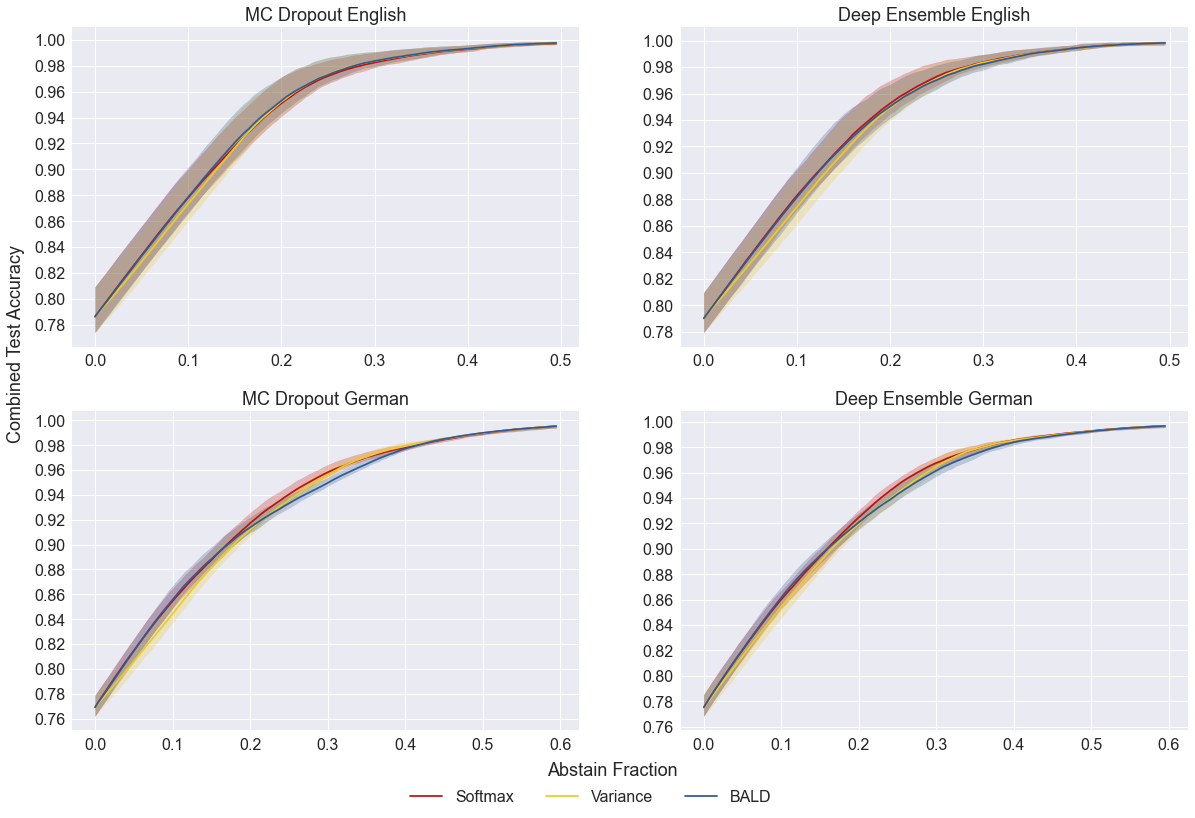

In [31]:
create_accuracy_plot_activation_functions(df_list, 100,plot_limit_german=120,plot_limit_romanian=30, in_domain=in_domain)

# Accuracy-Reject Curves

In [812]:
if in_domain:
    df_list_accuracy = [Vanilla, MCDropout,DeepEnsemble,Random_Class,Vanilla_german, MCDropout_german,DeepEnsemble_german,Random_Class_german,Vanilla_romanian, MCDropout_romanian,DeepEnsemble_romanian,Random_Class_romanian]
else:
    df_list_accuracy = [Vanilla, MCDropout,DeepEnsemble,Random_Class,Vanilla_german, MCDropout_german,DeepEnsemble_german,Random_Class_german]
    

In [772]:
def create_accuracy_plot_compare_text(df_list_accuracy, plot_limit, plot_limit_german,plot_limit_romanian, in_domain):
    
    if in_domain:
        Vanilla_list, MCDropout_list,DeepEnsemble_list,Random_Class_list,Vanilla_german_list, MCDropout_list_german,DeepEnsemble_list_german,Random_Class_list_german,Vanilla_romanian_list, MCDropout_list_romanian,DeepEnsemble_list_romanian,Random_Class_list_romanian = df_list_accuracy
        mc_ens_list = [MCDropout_list,DeepEnsemble_list,MCDropout_list_german,DeepEnsemble_list_german,MCDropout_list_romanian,DeepEnsemble_list_romanian]
    else:
        Vanilla_list, MCDropout_list,DeepEnsemble_list,Random_Class_list,Vanilla_german_list, MCDropout_list_german,DeepEnsemble_list_german,Random_Class_list_german = df_list_accuracy
        mc_ens_list = [MCDropout_list,DeepEnsemble_list,MCDropout_list_german,DeepEnsemble_list_german]
        
    
    
    Vanilla= Vanilla_list[0]
    
    model_accuracy_vanilla = Vanilla["AbstainAccuracy_Softmax_Acc"]
    combined_accuracy_vanilla = Vanilla["AbstainAccuracy_Softmax_CombinedAcc"]
    min_combined_accuracy_vanilla = Vanilla["min_AbstainAccuracy_Softmax_CombinedAcc"]
    max_combined_accuracy_vanilla = Vanilla["max_AbstainAccuracy_Softmax_CombinedAcc"]
    
    precision_vanilla = Vanilla["AbstainPrecision_Softmax"]
    min_precision_vanilla = Vanilla["min_AbstainPrecision_Softmax"]
    max_precision_vanilla = Vanilla["max_AbstainPrecision_Softmax"]
    
    recall_vanilla = Vanilla["AbstainRecall_Softmax"]
    min_recall_vanilla = Vanilla["min_AbstainRecall_Softmax"]
    max_recall_vanilla = Vanilla["max_AbstainRecall_Softmax"]
   
    Vanilla_german = Vanilla_german_list[0]
    
    model_accuracy_vanilla_german = Vanilla_german["AbstainAccuracy_Softmax_Acc"]
    combined_accuracy_vanilla_german = Vanilla_german["AbstainAccuracy_Softmax_CombinedAcc"]
    min_combined_accuracy_vanilla_german = Vanilla_german["min_AbstainAccuracy_Softmax_CombinedAcc"]
    max_combined_accuracy_vanilla_german = Vanilla_german["max_AbstainAccuracy_Softmax_CombinedAcc"]
    
    precision_vanilla_german = Vanilla_german["AbstainPrecision_Softmax"]
    min_precision_vanilla_german = Vanilla_german["min_AbstainPrecision_Softmax"]
    max_precision_vanilla_german = Vanilla_german["max_AbstainPrecision_Softmax"]
    
    recall_vanilla_german = Vanilla_german["AbstainRecall_Softmax"]
    min_recall_vanilla_german = Vanilla_german["min_AbstainRecall_Softmax"]
    max_recall_vanilla_german = Vanilla_german["max_AbstainRecall_Softmax"]

    if in_domain:
        Vanilla_romania = Vanilla_romanian_list[0]

        model_accuracy_vanilla_romanian = Vanilla_romania["AbstainAccuracy_Softmax_Acc"]
        combined_accuracy_vanilla_romanian = Vanilla_romania["AbstainAccuracy_Softmax_CombinedAcc"]
        min_combined_accuracy_vanilla_romanian = Vanilla_romania["min_AbstainAccuracy_Softmax_CombinedAcc"]
        max_combined_accuracy_vanilla_romanian = Vanilla_romania["max_AbstainAccuracy_Softmax_CombinedAcc"]

        precision_vanilla_romanian = Vanilla_romania["AbstainPrecision_Softmax"]
        min_precision_vanilla_romanian = Vanilla_romania["min_AbstainPrecision_Softmax"]
        max_precision_vanilla_romanian = Vanilla_romania["max_AbstainPrecision_Softmax"]

        recall_vanilla_romanian = Vanilla_romania["AbstainRecall_Softmax"]
        min_recall_vanilla_romanian = Vanilla_romania["min_AbstainRecall_Softmax"]
        max_recall_vanilla_romanian = Vanilla_romania["max_AbstainRecall_Softmax"]
    

    
    
    Random_Class= Random_Class_list[0]
    model_accuracy_random = Random_Class["AbstainAccuracy_Random_Acc"]
    combined_accuracy_random = Random_Class["AbstainAccuracy_Random_CombinedAcc"]
    min_combined_accuracy_random = Random_Class["min_AbstainAccuracy_Random_CombinedAcc"]
    max_combined_accuracy_random = Random_Class["max_AbstainAccuracy_Random_CombinedAcc"]

    
    model_accuracy_class = Random_Class["AbstainAccuracy_Class_Acc"]
    combined_accuracy_class = Random_Class["AbstainAccuracy_Class_CombinedAcc"]
    min_combined_accuracy_class = Random_Class["min_AbstainAccuracy_Class_CombinedAcc"]
    max_combined_accuracy_class = Random_Class["max_AbstainAccuracy_Class_CombinedAcc"]
    
    precision_random = Random_Class["AbstainPrecision_Random"]
    min_precision_random = Random_Class["min_AbstainPrecision_Random"]
    max_precision_random = Random_Class["max_AbstainPrecision_Random"]
    
    recall_random = Random_Class["AbstainRecall_Random"]
    min_recall_random = Random_Class["min_AbstainRecall_Random"]
    max_recall_random = Random_Class["max_AbstainRecall_Random"]
    
    precision_class = Random_Class["AbstainPrecision_Class"]
    min_precision_class = Random_Class["min_AbstainPrecision_Class"]
    max_precision_class = Random_Class["max_AbstainPrecision_Class"]
    
    recall_class = Random_Class["AbstainRecall_Class"]
    min_recall_class = Random_Class["min_AbstainRecall_Class"]
    max_recall_class = Random_Class["max_AbstainRecall_Class"]
    
    
    Random_Class_german = Random_Class_list_german[0]
    
    model_accuracy_random_german = Random_Class_german["AbstainAccuracy_Random_Acc"]
    combined_accuracy_random_german = Random_Class_german["AbstainAccuracy_Random_CombinedAcc"]
    min_combined_accuracy_random_german = Random_Class_german["min_AbstainAccuracy_Random_CombinedAcc"]
    max_combined_accuracy_random_german = Random_Class_german["max_AbstainAccuracy_Random_CombinedAcc"]
    
    model_accuracy_class_german = Random_Class_german["AbstainAccuracy_Class_Acc"]
    combined_accuracy_class_german = Random_Class_german["AbstainAccuracy_Class_CombinedAcc"]
    min_combined_accuracy_class_german = Random_Class_german["min_AbstainAccuracy_Class_CombinedAcc"]
    max_combined_accuracy_class_german = Random_Class_german["max_AbstainAccuracy_Class_CombinedAcc"]
    
    precision_random_german = Random_Class_german["AbstainPrecision_Random"]
    min_precision_random_german = Random_Class_german["min_AbstainPrecision_Random"]
    max_precision_random_german = Random_Class_german["max_AbstainPrecision_Random"]
    
    recall_random_german = Random_Class_german["AbstainRecall_Random"]
    min_recall_random_german = Random_Class_german["min_AbstainRecall_Random"]
    max_recall_random_german = Random_Class_german["max_AbstainRecall_Random"]
    
    precision_class_german = Random_Class_german["AbstainPrecision_Class"]
    min_precision_class_german = Random_Class_german["min_AbstainPrecision_Class"]
    max_precision_class_german = Random_Class_german["max_AbstainPrecision_Class"]
    
    recall_class_german = Random_Class_german["AbstainRecall_Class"]
    min_recall_class_german = Random_Class_german["min_AbstainRecall_Class"]
    max_recall_class_german = Random_Class_german["max_AbstainRecall_Class"]
    
    if in_domain:        
        Random_Class_romanian = Random_Class_list_romanian[0]

        model_accuracy_random_romanian = Random_Class_romanian["AbstainAccuracy_Random_Acc"]
        combined_accuracy_random_romanian = Random_Class_romanian["AbstainAccuracy_Random_CombinedAcc"]
        min_combined_accuracy_random_romanian = Random_Class_romanian["min_AbstainAccuracy_Random_CombinedAcc"]
        max_combined_accuracy_random_romanian = Random_Class_romanian["max_AbstainAccuracy_Random_CombinedAcc"]

        model_accuracy_class_romanian = Random_Class_romanian["AbstainAccuracy_Class_Acc"]
        combined_accuracy_class_romanian = Random_Class_romanian["AbstainAccuracy_Class_CombinedAcc"]
        min_combined_accuracy_class_romanian = Random_Class_romanian["min_AbstainAccuracy_Class_CombinedAcc"]
        max_combined_accuracy_class_romanian = Random_Class_romanian["max_AbstainAccuracy_Class_CombinedAcc"]

        precision_random_romanian = Random_Class_romanian["AbstainPrecision_Random"]
        min_precision_random_romanian = Random_Class_romanian["min_AbstainPrecision_Random"]
        max_precision_random_romanian = Random_Class_romanian["max_AbstainPrecision_Random"]

        recall_random_romanian = Random_Class_romanian["AbstainRecall_Random"]
        min_recall_random_romanian = Random_Class_romanian["min_AbstainRecall_Random"]
        max_recall_random_romanian = Random_Class_romanian["max_AbstainRecall_Random"]

        precision_class_romanian = Random_Class_romanian["AbstainPrecision_Class"]
        min_precision_class_romanian = Random_Class_romanian["min_AbstainPrecision_Class"]
        max_precision_class_romanian = Random_Class_romanian["max_AbstainPrecision_Class"]

        recall_class_romanian = Random_Class_romanian["AbstainRecall_Class"]
        min_recall_class_romanian = Random_Class_romanian["min_AbstainRecall_Class"]
        max_recall_class_romanian = Random_Class_romanian["max_AbstainRecall_Class"]
    
    data_MC = defaultdict(dict)
    data_MC_german = defaultdict(dict)
    data_MC_romanian = defaultdict(dict)
    data_Ensembles = defaultdict(dict)
    data_Ensembles_german = defaultdict(dict)
    data_Ensembles_romanian = defaultdict(dict)
    
    
    dicts = [data_MC,data_Ensembles, data_MC_german,data_Ensembles_german, data_MC_romanian,data_Ensembles_romanian]
    
    for x, j in enumerate(mc_ens_list):
        #print(x)
        for i in j:
            dicts[x]["model accuracy softmax"]["num ensembles:" + str(i["num_ensemble"].iloc[0])] = i["AbstainAccuracy_Softmax_Acc"]
            dicts[x]["combined accuracy softmax"]["num ensembles:" + str(i["num_ensemble"].iloc[0])] = i["AbstainAccuracy_Softmax_CombinedAcc"]
            dicts[x]["min combined accuracy softmax"]["num ensembles:" + str(i["num_ensemble"].iloc[0])] = i["min_AbstainAccuracy_Softmax_CombinedAcc"]
            dicts[x]["max combined accuracy softmax"]["num ensembles:" + str(i["num_ensemble"].iloc[0])] = i["max_AbstainAccuracy_Softmax_CombinedAcc"]

            dicts[x]["precision softmax"]["num ensembles:" + str(i["num_ensemble"].iloc[0])] = i["AbstainPrecision_Softmax"]
            dicts[x]["min precision softmax"]["num ensembles:" + str(i["num_ensemble"].iloc[0])] = i["min_AbstainPrecision_Softmax"]
            dicts[x]["max precision softmax"]["num ensembles:" + str(i["num_ensemble"].iloc[0])] = i["max_AbstainPrecision_Softmax"]        

            dicts[x]["recall softmax"]["num ensembles:" + str(i["num_ensemble"].iloc[0])] = i["AbstainRecall_Softmax"]
            dicts[x]["min recall softmax"]["num ensembles:" + str(i["num_ensemble"].iloc[0])] = i["min_AbstainRecall_Softmax"]
            dicts[x]["max recall softmax"]["num ensembles:" + str(i["num_ensemble"].iloc[0])] = i["max_AbstainRecall_Softmax"]        


    fraction_unlimited = MCDropout_list[0]['Abstain Fraction']
    fraction_limited = MCDropout_list[0]['Abstain Fraction'][:plot_limit]
    fraction_limited_german = MCDropout_list_german[0]['Abstain Fraction'][:plot_limit_german]
    if in_domain:
        fraction_limited_romanian = MCDropout_list_romanian[0]['Abstain Fraction'][:plot_limit_romanian]

    
    fig = plt.figure(figsize=(20, 20))
    fig.tight_layout()

    plt.subplot(3, 2, 1)
    # "bo" is for "blue dot"
    plt.plot(fraction_limited, combined_accuracy_vanilla[:plot_limit], color=colors[0], label='model_accuracy_vanilla')
    plt.fill_between(fraction_limited,min_combined_accuracy_vanilla[:plot_limit],max_combined_accuracy_vanilla[:plot_limit],color=colors[0],alpha=0.25)
    plt.plot(fraction_limited, data_MC["combined accuracy softmax"]["num ensembles:100"][:plot_limit], color=colors[1], label='model accuracy softmax MCDropout')
    plt.fill_between(fraction_limited,data_MC["min combined accuracy softmax"]["num ensembles:100"][:plot_limit],data_MC["max combined accuracy softmax"]["num ensembles:100"][:plot_limit],color=colors[1],alpha=0.25)
    plt.plot(fraction_limited, data_Ensembles["combined accuracy softmax"]["num ensembles:10"][:plot_limit], color=colors[2], label='model accuracy softmax Ensemble')
    plt.fill_between(fraction_limited,data_Ensembles["min combined accuracy softmax"]["num ensembles:10"][:plot_limit],data_Ensembles["max combined accuracy softmax"]["num ensembles:10"][:plot_limit],color=colors[2],alpha=0.25)
    plt.plot(fraction_limited, combined_accuracy_random[:plot_limit], color=colors[3], label='model accuracy random')
    plt.fill_between(fraction_limited,min_combined_accuracy_random[:plot_limit],max_combined_accuracy_random[:plot_limit],color=colors[3],alpha=0.25)
    plt.plot(fraction_limited, combined_accuracy_class[:plot_limit], color=colors[4], label='model accuracy class')
    plt.fill_between(fraction_limited,min_combined_accuracy_class[:plot_limit],max_combined_accuracy_class[:plot_limit],color=colors[4],alpha=0.25)
    if in_domain:
        plt.yticks(np.arange(0.82,1.019,step=0.02))
    else:
        plt.yticks(np.arange(0.76,1.019,step=0.02))
    #plt.ylabel('Combined Test Accuracy')
    #plt.xlabel('Abstain Fraction')
    #plt.title('Validation Accuracy')
    # plt.xlabel('Epochs')
    #plt.legend(loc='lower right')
    plt.title(label='English')
    
    
    plt.subplot(3, 2, 2)
    # "bo" is for "blue dot"
    plt.plot(fraction_limited[1:], precision_vanilla[1:plot_limit], color=colors[0], label='precision_vanilla')
    plt.fill_between(fraction_limited[1:],min_precision_vanilla[1:plot_limit],max_precision_vanilla[1:plot_limit],color=colors[0],alpha=0.25)
    plt.plot(fraction_limited[1:], data_MC["precision softmax"]["num ensembles:100"][1:plot_limit], color=colors[1], label='precision softmax MCDropout')
    plt.fill_between(fraction_limited[1:],data_MC["min precision softmax"]["num ensembles:100"][1:plot_limit],data_MC["max precision softmax"]["num ensembles:100"][1:plot_limit],color=colors[1],alpha=0.25)
    plt.plot(fraction_limited[1:], data_Ensembles["precision softmax"]["num ensembles:10"][1:plot_limit], color=colors[2], label='precision softmax Ensemble')
    plt.fill_between(fraction_limited[1:],data_Ensembles["min precision softmax"]["num ensembles:10"][1:plot_limit],data_Ensembles["max precision softmax"]["num ensembles:10"][1:plot_limit],color=colors[2],alpha=0.25)
    plt.plot(fraction_limited[1:], precision_random[1:plot_limit], color=colors[3], label='precision random')
    plt.fill_between(fraction_limited[1:],min_precision_random[1:plot_limit],max_precision_random[1:plot_limit],color=colors[3],alpha=0.25)
    plt.plot(fraction_limited[1:], precision_class[1:plot_limit], color=colors[4], label='precision class')
    plt.fill_between(fraction_limited[1:],min_precision_class[1:plot_limit],max_precision_class[1:plot_limit],color=colors[4],alpha=0.25)
    #plt.ylabel('Review Efficiency (Precision)')
    plt.title(label='English')
    


    
    plt.subplot(3, 2, 3)
    # "bo" is for "blue dot"
    plt.plot(fraction_limited_german, combined_accuracy_vanilla_german[:plot_limit_german], color=colors[0], label='combined_accuracy_vanilla')
    plt.fill_between(fraction_limited_german,min_combined_accuracy_vanilla_german[:plot_limit_german],max_combined_accuracy_vanilla_german[:plot_limit_german],color=colors[0],alpha=0.25)
    plt.plot(fraction_limited_german, data_MC_german["combined accuracy softmax"]["num ensembles:100"][:plot_limit_german], color=colors[1], label='combined accuracy softmax MCDropout')
    plt.fill_between(fraction_limited_german,data_MC_german["min combined accuracy softmax"]["num ensembles:100"][:plot_limit_german],data_MC_german["max combined accuracy softmax"]["num ensembles:100"][:plot_limit_german],color=colors[1],alpha=0.25)
    plt.plot(fraction_limited_german, data_Ensembles_german["combined accuracy softmax"]["num ensembles:10"][:plot_limit_german], color=colors[2], label='combined accuracy softmax Ensemble')
    plt.fill_between(fraction_limited_german,data_Ensembles_german["min combined accuracy softmax"]["num ensembles:10"][:plot_limit_german],data_Ensembles_german["max combined accuracy softmax"]["num ensembles:10"][:plot_limit_german],color=colors[2],alpha=0.25)
    plt.plot(fraction_limited_german, combined_accuracy_random_german[:plot_limit_german], color=colors[3], label='combined accuracy random')
    plt.fill_between(fraction_limited_german,min_combined_accuracy_random_german[:plot_limit_german],max_combined_accuracy_random_german[:plot_limit_german],color=colors[3],alpha=0.25)
    plt.plot(fraction_limited_german, combined_accuracy_class_german[:plot_limit_german], color=colors[4], label='combined accuracy class')
    plt.fill_between(fraction_limited_german,min_combined_accuracy_class_german[:plot_limit_german],max_combined_accuracy_class_german[:plot_limit_german],color=colors[4],alpha=0.25)
    plt.yticks(np.arange(0.76,1.019,step=0.02))
    #plt.ylabel('Combined Test Accuracy')
    plt.title(label='German')
    
    plt.subplot(3, 2, 4)
    # "bo" is for "blue dot"
    plt.plot(fraction_limited_german[1:], precision_vanilla_german[1:plot_limit_german], color=colors[0], label='precision_vanilla')
    plt.fill_between(fraction_limited_german[1:],min_precision_vanilla_german[1:plot_limit_german],max_precision_vanilla_german[1:plot_limit_german],color=colors[0],alpha=0.25)
    plt.plot(fraction_limited_german[1:], data_MC_german["precision softmax"]["num ensembles:100"][1:plot_limit_german], color=colors[1], label='precision softmax MCDropout')
    plt.fill_between(fraction_limited_german[1:],data_MC_german["min precision softmax"]["num ensembles:100"][1:plot_limit_german],data_MC_german["max precision softmax"]["num ensembles:100"][1:plot_limit_german],color=colors[1],alpha=0.25)
    plt.plot(fraction_limited_german[1:], data_Ensembles_german["precision softmax"]["num ensembles:10"][1:plot_limit_german], color=colors[2], label='precision softmax Ensemble')
    plt.fill_between(fraction_limited_german[1:],data_Ensembles_german["min precision softmax"]["num ensembles:10"][1:plot_limit_german],data_Ensembles_german["max precision softmax"]["num ensembles:10"][1:plot_limit_german],color=colors[2],alpha=0.25)
    plt.plot(fraction_limited_german[1:], precision_random_german[1:plot_limit_german], color=colors[3], label='precision random')
    plt.fill_between(fraction_limited_german[1:],min_precision_random_german[1:plot_limit_german],max_precision_random_german[1:plot_limit_german],color=colors[3],alpha=0.25)
    plt.plot(fraction_limited_german[1:], precision_class_german[1:plot_limit_german], color=colors[4], label='precision class')
    plt.fill_between(fraction_limited_german[1:],min_precision_class_german[1:plot_limit_german],max_precision_class_german[1:plot_limit_german],color=colors[4],alpha=0.25)
    plt.title(label='German')
    #plt.ylabel('Review Efficiency (Precision)')
    # plt.xlabel('Epochs')
    #plt.legend(loc='lower right')
        
    if in_domain:
        plt.subplot(3, 2, 5)
        # "bo" is for "blue dot"
        plt.plot(fraction_limited_romanian, combined_accuracy_vanilla_romanian[:plot_limit_romanian], color=colors[0], label='combined_accuracy_vanilla')
        plt.fill_between(fraction_limited_romanian,min_combined_accuracy_vanilla_romanian[:plot_limit_romanian],max_combined_accuracy_vanilla_romanian[:plot_limit_romanian],color=colors[0],alpha=0.25)
        plt.plot(fraction_limited_romanian, data_MC_romanian["combined accuracy softmax"]["num ensembles:100"][:plot_limit_romanian], color=colors[1], label='combined accuracy softmax MCDropout')
        plt.fill_between(fraction_limited_romanian,data_MC_romanian["min combined accuracy softmax"]["num ensembles:100"][:plot_limit_romanian],data_MC_romanian["max combined accuracy softmax"]["num ensembles:100"][:plot_limit_romanian],color=colors[1],alpha=0.25)
        plt.plot(fraction_limited_romanian, data_Ensembles_romanian["combined accuracy softmax"]["num ensembles:10"][:plot_limit_romanian], color=colors[2], label='combined accuracy softmax Ensemble')
        plt.fill_between(fraction_limited_romanian,data_Ensembles_romanian["min combined accuracy softmax"]["num ensembles:10"][:plot_limit_romanian],data_Ensembles_romanian["max combined accuracy softmax"]["num ensembles:10"][:plot_limit_romanian],color=colors[2],alpha=0.25)
        plt.plot(fraction_limited_romanian, combined_accuracy_random_romanian[:plot_limit_romanian], color=colors[3], label='combined accuracy random')
        plt.fill_between(fraction_limited_romanian,min_combined_accuracy_random_romanian[:plot_limit_romanian],max_combined_accuracy_random_romanian[:plot_limit_romanian],color=colors[3],alpha=0.25)
        plt.plot(fraction_limited_romanian, combined_accuracy_class_romanian[:plot_limit_romanian], color=colors[4], label='combined accuracy class')
        plt.fill_between(fraction_limited_romanian,min_combined_accuracy_class_romanian[:plot_limit_romanian],max_combined_accuracy_class_romanian[:plot_limit_romanian],color=colors[4],alpha=0.25)
        plt.yticks(np.arange(0.97,1.004,step=0.005))
        #plt.xlabel('Abstain Fraction')
        #plt.ylabel('Combined Test Accuracy')
        plt.title(label='Romanian')

        plt.subplot(3, 2, 6)
        # "bo" is for "blue dot"
        plt.plot(fraction_limited_romanian[1:], precision_vanilla_romanian[1:plot_limit_romanian], color=colors[0], label='precision_vanilla')
        plt.plot(fraction_limited_romanian[1:], data_MC_romanian["precision softmax"]["num ensembles:100"][1:plot_limit_romanian], color=colors[1], label='precision softmax MCDropout')
        plt.plot(fraction_limited_romanian[1:], data_Ensembles_romanian["precision softmax"]["num ensembles:10"][1:plot_limit_romanian], color=colors[2], label='precision softmax Ensemble')
        plt.plot(fraction_limited_romanian[1:], precision_random_romanian[1:plot_limit_romanian], color=colors[3], label='precision random')
        plt.plot(fraction_limited_romanian[1:], precision_class_romanian[1:plot_limit_romanian], color=colors[4], label='precision class')
        plt.fill_between(fraction_limited_romanian[1:],precision_vanilla_romanian[1:plot_limit_romanian],max_precision_vanilla_romanian[1:plot_limit_romanian],color=colors[0],alpha=0.25)
        plt.fill_between(fraction_limited_romanian[1:],data_MC_romanian["min precision softmax"]["num ensembles:100"][1:plot_limit_romanian],data_MC_romanian["max precision softmax"]["num ensembles:100"][1:plot_limit_romanian],color=colors[1],alpha=0.25)
        plt.fill_between(fraction_limited_romanian[1:],data_Ensembles_romanian["min precision softmax"]["num ensembles:10"][1:plot_limit_romanian],data_Ensembles_romanian["max precision softmax"]["num ensembles:10"][1:plot_limit_romanian],color=colors[2],alpha=0.25)
        plt.fill_between(fraction_limited_romanian[1:],precision_random_romanian[1:plot_limit_romanian],max_precision_random_romanian[1:plot_limit_romanian],color=colors[3],alpha=0.25)
        plt.fill_between(fraction_limited_romanian[1:],precision_class_romanian[1:plot_limit_romanian],max_precision_class_romanian[1:plot_limit_romanian],color=colors[4],alpha=0.25)
        plt.title(label='Romanian')
        #plt.ylabel('Review Efficiency (Precision)')
        #plt.xlabel('Abstain Fraction')


        labels=["Vanilla", "MC Dropout", "Deep Ensemble","Random","Class"]
        fig.legend(labels, loc='lower left', bbox_to_anchor=(0.23,0.06), ncol=len(labels), bbox_transform=fig.transFigure)

    else:
        labels=["Vanilla", "MC Dropout", "Deep Ensemble","Random","Class"]
        fig.legend(labels, loc='lower left', bbox_to_anchor=(0.23,0.325), ncol=len(labels), bbox_transform=fig.transFigure)
    

            
    if in_domain:
        fig.text(0.5, 0.09, 'Abstain Fraction', ha='center')
        fig.text(0.08, 0.5, 'Combined Test Accuracy', va='center', rotation='vertical')
        fig.text(0.51, 0.5, 'Review Efficiency (Precision)', va='center', rotation='vertical')
        fig.savefig('Accuracy-Reject Curves Combined.pdf')
    else:
        fig.text(0.5, 0.36, 'Abstain Fraction', ha='center')
        fig.text(0.08, 0.66, 'Combined Test Accuracy', va='center', rotation='vertical')
        fig.text(0.51, 0.66, 'Review Efficiency (Precision)', va='center', rotation='vertical')
        fig.savefig('Accuracy-Reject Curves Combined OOD.pdf')

    
    #fig.savefig("Accuracy-Reject Curves Combined.pdf")

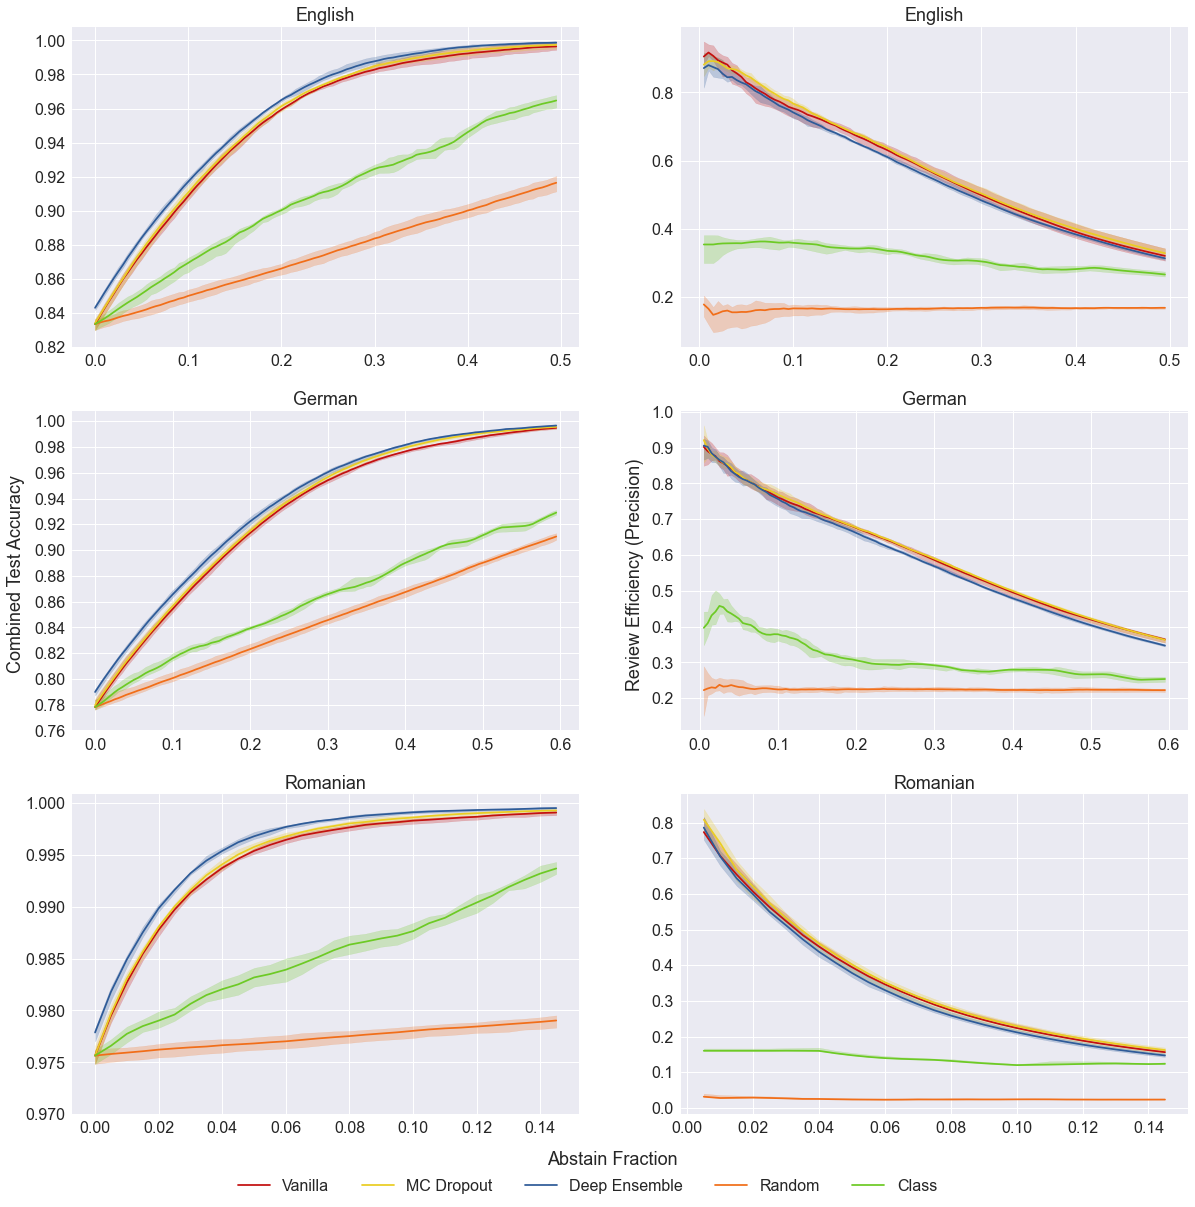

In [773]:
create_accuracy_plot_compare_text(df_list_accuracy,100,120,30,in_domain)

## Value

In [774]:
for i,x in enumerate(Vanilla):
    x["value"] = n_samples * x['Abstain Fraction'] * time_cost_manual/60 * (-hourly_wage) + (1-x["AbstainAccuracy_Softmax_CombinedAcc"]) * n_samples  * time_cost_rework/60 * (-hourly_wage) + vanilla_runtime_list[i]/60 * (-cost_runtime)/60
    x.reset_index(drop=True, inplace=True)
for i,x in enumerate(MCDropout):
    x["value"] = n_samples * x['Abstain Fraction'] * time_cost_manual/60 * (-hourly_wage) + (1-x["AbstainAccuracy_Softmax_CombinedAcc"]) * n_samples  * time_cost_rework/60 * (-hourly_wage) + dropout_runtime_list[i]/60 * (-cost_runtime)/60
    x.reset_index(drop=True, inplace=True)
for i,x in enumerate(DeepEnsemble):
    x["value"] = n_samples * x['Abstain Fraction'] * time_cost_manual/60 * (-hourly_wage) + (1-x["AbstainAccuracy_Softmax_CombinedAcc"]) * n_samples  * time_cost_rework/60 * (-hourly_wage) + ensemble_runtime_list[i]/60 * (-cost_runtime)/60    
    x.reset_index(drop=True, inplace=True)
    

for i,x in enumerate(Vanilla_german):
    x["value"] = n_samples_german * x['Abstain Fraction'] * time_cost_manual/60 * (-hourly_wage) + (1-x["AbstainAccuracy_Softmax_CombinedAcc"]) * n_samples_german  * time_cost_rework/60 * (-hourly_wage) +  vanilla_runtime_list_german[i]/60 * (-cost_runtime)/60
    x.reset_index(drop=True, inplace=True)
for i,x in enumerate(MCDropout_german):
    x["value"] = n_samples_german * x['Abstain Fraction'] * time_cost_manual/60 * (-hourly_wage) + (1-x["AbstainAccuracy_Softmax_CombinedAcc"]) * n_samples_german  * time_cost_rework/60 * (-hourly_wage) + dropout_runtime_list_german[i]/60 * (-cost_runtime)/60
    x.reset_index(drop=True, inplace=True)
for i,x in enumerate(DeepEnsemble_german):
    x["value"] = n_samples_german * x['Abstain Fraction'] * time_cost_manual/60 * (-hourly_wage) + (1-x["AbstainAccuracy_Softmax_CombinedAcc"]) * n_samples_german  * time_cost_rework/60 * (-hourly_wage) +  ensemble_runtime_list_german[i]/60 * (-cost_runtime)/60    
    x.reset_index(drop=True, inplace=True)

if in_domain:
    for i,x in enumerate(Vanilla_romanian):
        x["value"] = n_samples_romanian * x['Abstain Fraction'] * time_cost_manual/60 * (-hourly_wage) + (1-x["AbstainAccuracy_Softmax_CombinedAcc"]) * n_samples_romanian  * time_cost_rework/60 * (-hourly_wage) +  vanilla_runtime_list_romanian[i]/60 * (-cost_runtime)/60
        x.reset_index(drop=True, inplace=True)
    for i,x in enumerate(MCDropout_romanian):
        x["value"] = n_samples_romanian * x['Abstain Fraction'] * time_cost_manual/60 * (-hourly_wage) + (1-x["AbstainAccuracy_Softmax_CombinedAcc"]) * n_samples_romanian  * time_cost_rework/60 * (-hourly_wage) + dropout_runtime_list_romanian[i]/60 * (-cost_runtime)/60
        x.reset_index(drop=True, inplace=True)
    for i,x in enumerate(DeepEnsemble_romanian):
        x["value"] = n_samples_romanian * x['Abstain Fraction'] * time_cost_manual/60 * (-hourly_wage) + (1-x["AbstainAccuracy_Softmax_CombinedAcc"]) * n_samples_romanian  * time_cost_rework/60 * (-hourly_wage) + ensemble_runtime_list_romanian[i]/60 * (-cost_runtime)/60
        x.reset_index(drop=True, inplace=True)

In [775]:
print("Overall Minimum English:", Vanilla[0]["value"].min())
print("Overall Minimum German:", Vanilla_german[0]["value"].min())
if in_domain:
    print("Overall Minimum Romanian:", Vanilla_romanian[0]["value"].min())

print("Maximum English Vanilla:", Vanilla[0]["value"].max(), "achieved at", Vanilla[0].iloc[Vanilla[0]['value'].idxmax()]["Abstain Fraction"], "Abstain Fraction")
print("Maximum English MCDropout:", MCDropout[11]["value"].max(), "achieved at", MCDropout[11].iloc[MCDropout[11]['value'].idxmax()]["Abstain Fraction"], "Abstain Fraction")
print("Maximum English Deep Ensemble:", DeepEnsemble[7]["value"].max(), "achieved at", DeepEnsemble[7].iloc[DeepEnsemble[7]['value'].idxmax()]["Abstain Fraction"], "Abstain Fraction")

print("Maximum German Vanilla:", Vanilla_german[0]["value"].max(), "achieved at", Vanilla_german[0].iloc[Vanilla_german[0]['value'].idxmax()]["Abstain Fraction"], "Abstain Fraction")
print("Maximum German MCDropout:", MCDropout_german[11]["value"].max(), "achieved at", MCDropout_german[11].iloc[MCDropout_german[11]['value'].idxmax()]["Abstain Fraction"], "Abstain Fraction")
print("Maximum German Deep Ensemble:", DeepEnsemble_german[7]["value"].max(), "achieved at", DeepEnsemble_german[7].iloc[DeepEnsemble_german[7]['value'].idxmax()]["Abstain Fraction"], "Abstain Fraction")

if in_domain:
    ##attention: deviation for romanian
    print("Maximum Romanian Vanilla:", Vanilla_romanian[0]["value"].max(), "achieved at", Vanilla_romanian[0].iloc[Vanilla_romanian[0]['value'].idxmax()]["Abstain Fraction"], "Abstain Fraction")
    print("Maximum Romanian MCDropout:", MCDropout_romanian[2]["value"].max(), "achieved at", MCDropout_romanian[11].iloc[MCDropout_romanian[11]['value'].idxmax()]["Abstain Fraction"], "Abstain Fraction")
    print("Maximum Romanian Deep Ensemble:", DeepEnsemble_romanian[7]["value"].max(), "achieved at", DeepEnsemble_romanian[7].iloc[DeepEnsemble_romanian[7]['value'].idxmax()]["Abstain Fraction"], "Abstain Fraction")

Overall Minimum English: -1974.1701083333332
Overall Minimum German: -3549.3481083333336
Overall Minimum Romanian: -8894.182452777777
Maximum English Vanilla: -542.3776646129537 achieved at 0.145 Abstain Fraction
Maximum English MCDropout: -538.0069319489966 achieved at 0.15 Abstain Fraction
Maximum English Deep Ensemble: -517.1600757043184 achieved at 0.145 Abstain Fraction
Maximum German Vanilla: -1325.6075468103745 achieved at 0.2 Abstain Fraction
Maximum German MCDropout: -1313.3518803541763 achieved at 0.215 Abstain Fraction
Maximum German Deep Ensemble: -1261.8282460096611 achieved at 0.19 Abstain Fraction
Maximum Romanian Vanilla: -392.1592814185087 achieved at 0.015 Abstain Fraction
Maximum Romanian MCDropout: -388.0789832604062 achieved at 0.015 Abstain Fraction
Maximum Romanian Deep Ensemble: -356.3177772456326 achieved at 0.015 Abstain Fraction


In [776]:
if in_domain:
    df_list_accuracy_value= [Vanilla, MCDropout,DeepEnsemble,Random_Class,Vanilla_german, MCDropout_german,DeepEnsemble_german,Random_Class_german,Vanilla_romanian, MCDropout_romanian,DeepEnsemble_romanian,Random_Class_romanian]
else:
    df_list_accuracy_value= [Vanilla, MCDropout,DeepEnsemble,Random_Class,Vanilla_german, MCDropout_german,DeepEnsemble_german,Random_Class_german]

In [779]:
def create_accuracy_plot_value(df_list_accuracy_value,plot_limit, plot_limit_german,plot_limit_romanian, in_domain):
    
    if in_domain:
        Vanilla_list, MCDropout_list,DeepEnsemble_list,Random_Class_list,Vanilla_german_list, MCDropout_list_german,DeepEnsemble_list_german,Random_Class_list_german,Vanilla_romanian_list, MCDropout_list_romanian,DeepEnsemble_list_romanian,Random_Class_list_romanian = df_list_accuracy
        mc_ens_list = [MCDropout_list,DeepEnsemble_list,MCDropout_list_german,DeepEnsemble_list_german,MCDropout_list_romanian,DeepEnsemble_list_romanian]
    else:
        Vanilla_list, MCDropout_list,DeepEnsemble_list,Random_Class_list,Vanilla_german_list, MCDropout_list_german,DeepEnsemble_list_german,Random_Class_list_german = df_list_accuracy
        mc_ens_list = [MCDropout_list,DeepEnsemble_list,MCDropout_list_german,DeepEnsemble_list_german]
    
    Vanilla = Vanilla_list[0]
    combined_accuracy_vanilla = Vanilla["value"]

    Vanilla_german = Vanilla_german_list[0]
    combined_accuracy_vanilla_german = Vanilla_german["value"]

    if in_domain:
        Vanilla_romanian = Vanilla_romanian_list[0]
        combined_accuracy_vanilla_romanian = Vanilla_romanian["value"]
    


    data_MC = defaultdict(dict)
    data_MC_german = defaultdict(dict)
    data_MC_romanian = defaultdict(dict)
    data_Ensembles = defaultdict(dict)
    data_Ensembles_german = defaultdict(dict)
    data_Ensembles_romanian = defaultdict(dict)


    dicts = [data_MC,data_Ensembles, data_MC_german,data_Ensembles_german, data_MC_romanian,data_Ensembles_romanian]
    
    for x, j in enumerate(mc_ens_list):
        for i in j:
            dicts[x]["combined accuracy softmax"]["num ensembles:" + str(i["num_ensemble"].iloc[0])] = i["value"]

    fraction_unlimited = MCDropout[0]['Abstain Fraction']
    fraction_limited = MCDropout[0]['Abstain Fraction'][:plot_limit]
    fraction_limited_german = MCDropout_german[0]['Abstain Fraction'][:plot_limit_german]
    if in_domain:
        fraction_limited_romanian = MCDropout_romanian[0]['Abstain Fraction'][:plot_limit_romanian]

    
    fig = plt.figure(figsize=(20, 15))
    fig.tight_layout()

    plt.subplot(3, 1, 1)
    # "bo" is for "blue dot"
    plt.plot(fraction_limited, combined_accuracy_vanilla[:plot_limit], color=colors[0], label='model_accuracy_vanilla')
    plt.plot(fraction_limited, data_MC["combined accuracy softmax"]["num ensembles:100"][:plot_limit], color=colors[1], label='model accuracy softmax MCDropout')
    plt.plot(fraction_limited, data_Ensembles["combined accuracy softmax"]["num ensembles:10"][:plot_limit], color=colors[2], label='model accuracy softmax Ensemble')
    #plt.ylabel('Cost on test set (in €)')
    plt.ylim(-1000,-500)
    plt.title(label='English')
    
    plt.subplot(3, 1, 2)
    # "bo" is for "blue dot"
    plt.plot(fraction_limited_german, combined_accuracy_vanilla_german[:plot_limit_german], color=colors[0], label='combined_accuracy_vanilla')
    plt.plot(fraction_limited_german, data_MC_german["combined accuracy softmax"]["num ensembles:100"][:plot_limit_german], color=colors[1], label='combined accuracy softmax MCDropout')
    plt.plot(fraction_limited_german, data_Ensembles_german["combined accuracy softmax"]["num ensembles:10"][:plot_limit_german], color=colors[2], label='combined accuracy softmax Ensemble')

    #plt.ylabel('Cost on test set (in €)')
    plt.ylim(-2200,-1200)
    #plt.legend(loc='lower right')
    plt.title(label='German')
    
    if in_domain:
        plt.subplot(3, 1, 3)
        # "bo" is for "blue dot"
        plt.plot(fraction_limited_romanian, combined_accuracy_vanilla_romanian[:plot_limit_romanian], color=colors[0], label='combined_accuracy_vanilla')
        plt.plot(fraction_limited_romanian, data_MC_romanian["combined accuracy softmax"]["num ensembles:20"][:plot_limit_romanian], color=colors[1], label='combined accuracy softmax MCDropout')
        plt.plot(fraction_limited_romanian, data_Ensembles_romanian["combined accuracy softmax"]["num ensembles:10"][:plot_limit_romanian], color=colors[2], label='combined accuracy softmax Ensemble')
        #plt.xlabel('Abstain Fraction')
        #plt.ylabel('Cost on test set (in €)')
        plt.ylim(-1400,-200)
        plt.title(label='Romanian')

        labels=["Vanilla", "MC Dropout", "Deep Ensemble"]
        fig.legend(labels, loc='lower left', bbox_to_anchor=(0.36,0.04), ncol=len(labels), bbox_transform=fig.transFigure)

    else:
        labels=["Vanilla", "MC Dropout", "Deep Ensemble"]
        fig.legend(labels, loc='lower left', bbox_to_anchor=(0.36,0.31), ncol=len(labels), bbox_transform=fig.transFigure)
    

            
    if in_domain:
        fig.text(0.5, 0.08, 'Abstain Fraction', ha='center')
        fig.text(0.07, 0.5, 'Cost on test set (in €)', va='center', rotation='vertical')
        fig.savefig('Accuracy-Reject Curves Value.pdf')
    else:
        fig.text(0.5, 0.35, 'Abstain Fraction', ha='center')
        fig.text(0.07, 0.66, 'Cost on test set (in €)', va='center', rotation='vertical')
        fig.savefig('Accuracy-Reject Curves Value OOD.pdf')


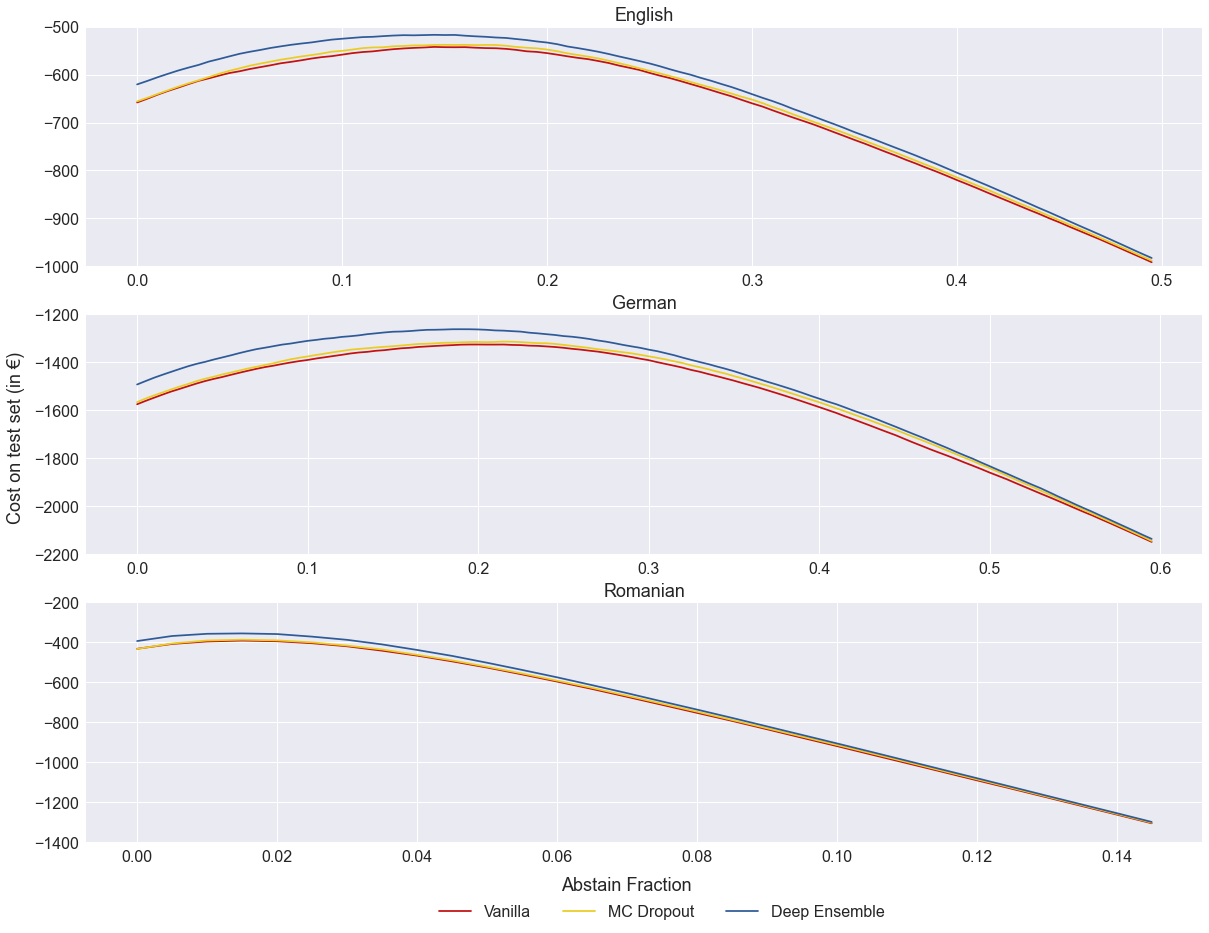

In [780]:
create_accuracy_plot_value(df_list_accuracy_value,100,120,30, in_domain)

# Additional Calibration Metrics (not included in thesis)

In [40]:
MCDropout_df = pd.concat(MCDropout)
DeepEnsemble_df = pd.concat(DeepEnsemble)
Vanilla_df = pd.concat(Vanilla)
Random_Class_df = pd.concat(Random_Class)

In [41]:
MCDropout_df_romanian = pd.concat(MCDropout_romanian)
DeepEnsemble_df_romanian = pd.concat(DeepEnsemble_romanian)
Vanilla_df_romanian = pd.concat(Vanilla_romanian)
Random_Class_df_romanian = pd.concat(Random_Class_romanian)

In [42]:
MCDropout_df_german = pd.concat(MCDropout_german)
DeepEnsemble_df_german = pd.concat(DeepEnsemble_german)
Vanilla_df_german = pd.concat(Vanilla_german)
Random_Class_df_german = pd.concat(Random_Class_german)

In [43]:
def create_table(df):
    df.head()
    df.drop_duplicates(subset=["num_ensemble"], inplace=True)
    df.drop(columns=["Abstain Fraction",'AbstainAccuracy_Softmax_Acc', 'AbstainAccuracy_Softmax_CombinedAcc',
       'AbstainAccuracy_Variance_Acc', 'AbstainAccuracy_Variance_CombinedAcc',
       'AbstainAccuracy_BALD_Acc', 'AbstainAccuracy_BALD_CombinedAcc',
       'AbstainPrecision_Softmax', 'AbstainPrecision_Variance',
       'AbstainPrecision_BALD', 'AbstainRecall_Softmax',
       'AbstainRecall_Variance', 'AbstainRecall_BALD'],inplace=True)
    df["num_ensemble"] = df["num_ensemble"].astype(int)
    df.sort_values("num_ensemble")
    df = df.set_index(["num_ensemble"])
    df.sort_index(inplace=True, level="num_ensemble")
    
    return df

In [44]:
MCDropout_df = create_table(MCDropout_df)

DeepEnsemble_df = create_table(DeepEnsemble_df)

Vanilla_df.drop_duplicates(subset=["num_ensemble"],inplace=True)
Vanilla_df.drop(columns=["Abstain Fraction","AbstainAccuracy_Softmax_Acc","AbstainAccuracy_Softmax_CombinedAcc","AbstainPrecision_Softmax",
                        "AbstainRecall_Softmax"], inplace=True)

Vanilla_df = Vanilla_df.set_index("num_ensemble")

Random_Class_df.drop_duplicates(subset=["num_ensemble"],inplace=True)

Random_Class_df.drop(columns=["ECE","BRIER","CalibAUROC Softmax",
                              "CalibAUPR Softmax",
                              "Abstain Fraction","AbstainAccuracy_Softmax_Acc","AbstainAccuracy_Softmax_CombinedAcc","AbstainPrecision_Softmax",
                        "AbstainRecall_Softmax"], inplace=True)

Random_Class_df = Random_Class_df.set_index("num_ensemble")

In [45]:
MCDropout_df_german = create_table(MCDropout_df_german)

DeepEnsemble_df_german = create_table(DeepEnsemble_df_german)

Vanilla_df_german.drop_duplicates(subset=["num_ensemble"],inplace=True)
Vanilla_df_german.drop(columns=["Abstain Fraction","AbstainAccuracy_Softmax_Acc","AbstainAccuracy_Softmax_CombinedAcc","AbstainPrecision_Softmax",
                        "AbstainRecall_Softmax"], inplace=True)

#iloc[0,:].drop(columns=["AbstainAccuracy_Softmax_Acc","AbstainAccuracy_Softmax_CombinedAcc","AbstainPrecision_Softmax",
                                 # "AbstainRecall_Softmax","method"])

Vanilla_df_german = Vanilla_df_german.set_index("num_ensemble")

Random_Class_df_german.drop_duplicates(subset=["num_ensemble"],inplace=True)

Random_Class_df_german.drop(columns=["ECE","BRIER","CalibAUROC Softmax",
                              "CalibAUPR Softmax",
                              "Abstain Fraction","AbstainAccuracy_Softmax_Acc","AbstainAccuracy_Softmax_CombinedAcc","AbstainPrecision_Softmax",
                        "AbstainRecall_Softmax"], inplace=True)

Random_Class_df_german = Random_Class_df_german.set_index("num_ensemble")

In [46]:
MCDropout_df_romanian = create_table(MCDropout_df_romanian)

DeepEnsemble_df_romanian = create_table(DeepEnsemble_df_romanian)

Vanilla_df_romanian.drop_duplicates(subset=["num_ensemble"],inplace=True)
Vanilla_df_romanian.drop(columns=["Abstain Fraction","AbstainAccuracy_Softmax_Acc","AbstainAccuracy_Softmax_CombinedAcc","AbstainPrecision_Softmax",
                        "AbstainRecall_Softmax"], inplace=True)

#iloc[0,:].drop(columns=["AbstainAccuracy_Softmax_Acc","AbstainAccuracy_Softmax_CombinedAcc","AbstainPrecision_Softmax",
                                 # "AbstainRecall_Softmax","method"])

Vanilla_df_romanian = Vanilla_df_romanian.set_index("num_ensemble")

Random_Class_df_romanian.drop_duplicates(subset=["num_ensemble"],inplace=True)

Random_Class_df_romanian.drop(columns=["ECE","BRIER","CalibAUROC Softmax",
                              "CalibAUPR Softmax",
                              "Abstain Fraction","AbstainAccuracy_Softmax_Acc","AbstainAccuracy_Softmax_CombinedAcc","AbstainPrecision_Softmax",
                        "AbstainRecall_Softmax"], inplace=True)

Random_Class_df_romanian = Random_Class_df_romanian.set_index("num_ensemble")

In [47]:
def function_to_split(hand,labl,dividor):

    Hand_L=[]
    Hand_M=[]
    Labl_L=[]
    Labl_M=[]

    for h,l in zip(hand,labl):
        co=h.get_color()
        ls=h.get_linestyle()
        lw=h.get_linewidth()
        mk=h.get_marker()
        mew=h.get_markeredgewidth()
        ms=h.get_markersize()

        LABS=l.split(dividor)

        if len(LABS) != 2:
            print('Split Legends Error: Only exactly 1 Dividor is accepted.')
            print ('Currently ' + str(len(LABS)-1) + ' dividors were given')
            return hand,labl

        #Line and Color
        LICO = plt.Line2D((0,1),(0,0), color=co, marker='',linewidth=lw)
        #Marker
        MARK = plt.Line2D((0,1),(0,0), color='k', marker=mk, markeredgewidth=mew, markersize=ms, linestyle=ls)

        if LABS[0] not in Labl_L:
            Hand_L.append(LICO)
            Labl_L.append(LABS[0])

        if LABS[1] not in Labl_M:
            Hand_M.append(MARK)
            Labl_M.append(LABS[1])

    return Hand_L+Hand_M,Labl_L+Labl_M

In [48]:
def plot_metrics(Vanilla_df,MCDropout_df,DeepEnsemble_df,Random_Class_df, language):
    fig = plt.figure(figsize=(20, 20))
    fig.tight_layout()


    num_ensemble_MC = np.array(MCDropout_df.index)
    num_ensemble_DeepEnsemble = np.array(DeepEnsemble_df.index)

    plt.subplot(3, 2, 1)
    #ECE_Softmax = plt.plot(num_ensemble_DeepEnsemble, DeepEnsemble_df["ECE"], color=colors[0], label="Deep Ensemble & Softmax")
    
    
    ECE_VANILLA = plt.axhline(y=Vanilla_df["ECE"].iloc[0], color=colors[0], linestyle='-',xmin=0.045,xmax=0.955, label="Vanilla & Softmax")
    plt.fill_between(num_ensemble_MC,Vanilla_df["min_ECE"],Vanilla_df["max_ECE"],color=colors[0],alpha=0.25)
    ECE_MCDROPOUT = plt.plot(num_ensemble_MC, MCDropout_df["ECE"], color=colors[1], label="MC Dropout & Softmax")
    plt.fill_between(num_ensemble_MC,MCDropout_df["min_ECE"],MCDropout_df["max_ECE"],color=colors[1],alpha=0.25)
    plt.plot(num_ensemble_DeepEnsemble, DeepEnsemble_df["ECE"], color=colors[2], label="Deep Ensemble & Softmax")
    plt.fill_between(num_ensemble_DeepEnsemble,DeepEnsemble_df["min_ECE"],DeepEnsemble_df["max_ECE"],color=colors[2],alpha=0.25)
    
    plt.title("ECE")
    plt.ylabel('ECE')

    plt.subplot(3, 2, 2)
    plt.plot(num_ensemble_DeepEnsemble, DeepEnsemble_df["BRIER"], color=colors[2], label="Deep Ensemble & Softmax")
    plt.fill_between(num_ensemble_DeepEnsemble,DeepEnsemble_df["min_BRIER"],DeepEnsemble_df["max_BRIER"],color=colors[2],alpha=0.25)    
    plt.plot(num_ensemble_MC, MCDropout_df["BRIER"], color=colors[1], label="MC Dropout & Softmax")
    plt.fill_between(num_ensemble_MC,MCDropout_df["min_BRIER"],MCDropout_df["max_BRIER"],color=colors[1],alpha=0.25)
    plt.axhline(y=Vanilla_df["BRIER"].iloc[0], color=colors[0], linestyle='-',xmin=0.045,xmax=0.955, label="Vanilla & Softmax")
    plt.fill_between(num_ensemble_MC,Vanilla_df["min_BRIER"],Vanilla_df["max_BRIER"],color=colors[0],alpha=0.25)
    plt.title("BRIER")
    plt.ylabel('BRIER')

    plt.subplot(3, 2, 3)
    plt.plot(num_ensemble_DeepEnsemble, DeepEnsemble_df["CalibAUROC Softmax"], color=colors[2], label="Deep Ensemble & Softmax")
    plt.fill_between(num_ensemble_DeepEnsemble,DeepEnsemble_df["min_CalibAUROC Softmax"],DeepEnsemble_df["max_CalibAUROC Softmax"],color=colors[2],alpha=0.25)
    plt.plot(num_ensemble_DeepEnsemble, DeepEnsemble_df["CalibAUROC Variance"], color=colors[2], linestyle="--", label="Deep Ensemble & Variance")
    plt.fill_between(num_ensemble_DeepEnsemble,DeepEnsemble_df["min_CalibAUROC Variance"],DeepEnsemble_df["max_CalibAUROC Variance"],color=colors[2],alpha=0.25)
    plt.plot(num_ensemble_DeepEnsemble, DeepEnsemble_df["CalibAUROC BALD"], color=colors[2], linestyle=":", label="Deep Ensemble & BALD")
    plt.fill_between(num_ensemble_DeepEnsemble,DeepEnsemble_df["min_CalibAUROC BALD"],DeepEnsemble_df["max_CalibAUROC BALD"],color=colors[2],alpha=0.25)
    plt.plot(num_ensemble_MC, MCDropout_df["CalibAUROC Softmax"], color=colors[1], label="MC Dropout & Softmax")
    plt.fill_between(num_ensemble_MC,MCDropout_df["min_CalibAUROC Softmax"],MCDropout_df["max_CalibAUROC Softmax"],color=colors[1],alpha=0.25)
    plt.plot(num_ensemble_MC, MCDropout_df["CalibAUROC Variance"], color=colors[1],linestyle="--", label="MC Dropout & Variance")
    plt.fill_between(num_ensemble_MC,MCDropout_df["min_CalibAUROC Variance"],MCDropout_df["max_CalibAUROC Variance"],color=colors[1],alpha=0.25)
    plt.plot(num_ensemble_MC, MCDropout_df["CalibAUROC BALD"], color=colors[1], linestyle=":", label="MC Dropout & BALD")
    plt.fill_between(num_ensemble_MC,MCDropout_df["min_CalibAUROC BALD"],MCDropout_df["max_CalibAUROC BALD"],color=colors[1],alpha=0.25)
    plt.axhline(y=Vanilla_df["CalibAUROC Softmax"].iloc[0], color=colors[0], linestyle='-',xmin=0.045,xmax=0.955, label="Vanilla & Softmax")
    plt.fill_between(num_ensemble_MC,Vanilla_df["min_CalibAUROC Softmax"],Vanilla_df["max_CalibAUROC Softmax"],color=colors[0],alpha=0.25)
    plt.axhline(y=MCDropout_df["CalibAUROC Random"].iloc[0], color=colors[3], linestyle='-',xmin=0.045,xmax=0.955,label= "Random & Softmax")
    plt.fill_between(num_ensemble_MC,Vanilla_df["min_CalibAUROC Random"],Vanilla_df["max_CalibAUROC Random"],color=colors[3],alpha=0.25)
    plt.axhline(y=MCDropout_df["CalibAUROC Class"].iloc[0], color=colors[4], linestyle='-',xmin=0.045,xmax=0.955, label="Class & Softmax")
    plt.fill_between(num_ensemble_MC,Vanilla_df["min_CalibAUROC Class"],Vanilla_df["max_CalibAUROC Class"],color=colors[4],alpha=0.25)
    plt.title("Calib AUROC With Baseline")
    plt.ylabel('CalibAUROC')
    #plt.legend(loc='lower right')

    plt.subplot(3, 2, 4)
    plt.plot(num_ensemble_DeepEnsemble, DeepEnsemble_df["CalibAUROC Softmax"], color=colors[2], label="Deep Ensemble & Softmax")
    plt.fill_between(num_ensemble_DeepEnsemble,DeepEnsemble_df["min_CalibAUROC Softmax"],DeepEnsemble_df["max_CalibAUROC Softmax"],color=colors[2],alpha=0.25)
    plt.plot(num_ensemble_DeepEnsemble, DeepEnsemble_df["CalibAUROC Variance"], color=colors[2], linestyle="--", label="Deep Ensemble & Variance")
    plt.fill_between(num_ensemble_DeepEnsemble,DeepEnsemble_df["min_CalibAUROC Variance"],DeepEnsemble_df["max_CalibAUROC Variance"],color=colors[2],alpha=0.25)
    plt.plot(num_ensemble_DeepEnsemble, DeepEnsemble_df["CalibAUROC BALD"], color=colors[2], linestyle=":", label="Deep Ensemble & BALD")
    plt.fill_between(num_ensemble_DeepEnsemble,DeepEnsemble_df["min_CalibAUROC BALD"],DeepEnsemble_df["max_CalibAUROC BALD"],color=colors[2],alpha=0.25)
    plt.plot(num_ensemble_MC, MCDropout_df["CalibAUROC Softmax"], color=colors[1], label="MC Dropout & Softmax")
    plt.fill_between(num_ensemble_MC,MCDropout_df["min_CalibAUROC Softmax"],MCDropout_df["max_CalibAUROC Softmax"],color=colors[1],alpha=0.25)
    plt.plot(num_ensemble_MC, MCDropout_df["CalibAUROC Variance"], color=colors[1],linestyle="--", label="MC Dropout & Variance")
    plt.fill_between(num_ensemble_MC,MCDropout_df["min_CalibAUROC Variance"],MCDropout_df["max_CalibAUROC Variance"],color=colors[1],alpha=0.25)
    plt.plot(num_ensemble_MC, MCDropout_df["CalibAUROC BALD"], color=colors[1], linestyle=":", label="MC Dropout & BALD")
    plt.fill_between(num_ensemble_MC,MCDropout_df["min_CalibAUROC BALD"],MCDropout_df["max_CalibAUROC BALD"],color=colors[1],alpha=0.25)
    plt.axhline(y=Vanilla_df["CalibAUROC Softmax"].iloc[0], color=colors[0], linestyle='-',xmin=0.045,xmax=0.955, label="Vanilla & Softmax")
    plt.fill_between(num_ensemble_MC,Vanilla_df["min_CalibAUROC Softmax"],Vanilla_df["max_CalibAUROC Softmax"],color=colors[0],alpha=0.25)

    plt.title("Calib AUROC Without Baseline")
    plt.ylabel('CalibAUROC')
    #plt.legend(loc='lower right')

    plt.subplot(3, 2, 5)
    
    plt.plot(num_ensemble_DeepEnsemble, DeepEnsemble_df["CalibAUPR Softmax"], color=colors[2], label="Deep Ensemble & Softmax")
    plt.fill_between(num_ensemble_DeepEnsemble,DeepEnsemble_df["min_CalibAUPR Softmax"],DeepEnsemble_df["max_CalibAUPR Softmax"],color=colors[2],alpha=0.25)
    plt.plot(num_ensemble_DeepEnsemble, DeepEnsemble_df["CalibAUPR Variance"], color=colors[2], linestyle="--", label="Deep Ensemble & Variance")
    plt.fill_between(num_ensemble_DeepEnsemble,DeepEnsemble_df["min_CalibAUPR Variance"],DeepEnsemble_df["max_CalibAUPR Variance"],color=colors[2],alpha=0.25)
    plt.plot(num_ensemble_DeepEnsemble, DeepEnsemble_df["CalibAUPR BALD"], color=colors[2], linestyle=":", label="Deep Ensemble & BALD")
    plt.fill_between(num_ensemble_DeepEnsemble,DeepEnsemble_df["min_CalibAUPR BALD"],DeepEnsemble_df["max_CalibAUPR BALD"],color=colors[2],alpha=0.25)
    plt.plot(num_ensemble_MC, MCDropout_df["CalibAUPR Softmax"], color=colors[1], label="MC Dropout & Softmax")
    plt.fill_between(num_ensemble_MC,MCDropout_df["min_CalibAUPR Softmax"],MCDropout_df["max_CalibAUPR Softmax"],color=colors[1],alpha=0.25)
    plt.plot(num_ensemble_MC, MCDropout_df["CalibAUPR Variance"], color=colors[1],linestyle="--", label="MC Dropout & Variance")
    plt.fill_between(num_ensemble_MC,MCDropout_df["min_CalibAUPR Variance"],MCDropout_df["max_CalibAUPR Variance"],color=colors[1],alpha=0.25)
    plt.plot(num_ensemble_MC, MCDropout_df["CalibAUPR BALD"], color=colors[1], linestyle=":", label="MC Dropout & BALD")
    plt.fill_between(num_ensemble_MC,MCDropout_df["min_CalibAUPR BALD"],MCDropout_df["max_CalibAUPR BALD"],color=colors[1],alpha=0.25)
    plt.axhline(y=Vanilla_df["CalibAUPR Softmax"].iloc[0], color=colors[2], linestyle='-',xmin=0.045,xmax=0.955, label="Vanilla & Softmax")
    plt.fill_between(num_ensemble_MC,Vanilla_df["min_CalibAUPR Softmax"],Vanilla_df["max_CalibAUPR Softmax"],color=colors[2],alpha=0.25)
    plt.axhline(y=MCDropout_df["CalibAUPR Random"].iloc[0], color=colors[3], linestyle='-',xmin=0.045,xmax=0.955,label= "Random & Softmax")
    plt.fill_between(num_ensemble_MC,Vanilla_df["min_CalibAUPR Random"],Vanilla_df["max_CalibAUPR Random"],color=colors[3],alpha=0.25)
    plt.axhline(y=MCDropout_df["CalibAUPR Class"].iloc[0], color=colors[4], linestyle='-',xmin=0.045,xmax=0.955, label="Class & Softmax")
    plt.fill_between(num_ensemble_MC,Vanilla_df["min_CalibAUPR Class"],Vanilla_df["max_CalibAUPR Class"],color=colors[4],alpha=0.25)
    plt.plot(num_ensemble_DeepEnsemble, DeepEnsemble_df["CalibAUPR Softmax"], color=colors[0], label="Deep Ensemble & Softmax")
    plt.fill_between(num_ensemble_DeepEnsemble,DeepEnsemble_df["min_CalibAUPR Softmax"],DeepEnsemble_df["max_CalibAUPR Softmax"],color=colors[0],alpha=0.25)

    plt.title("Calib AUPR Without Baseline")
    plt.ylabel('CalibAUPR')
    plt.xlabel("Ensembles")
    #plt.legend(loc='lower right')

    plt.subplot(3, 2, 6)
    plt.plot(num_ensemble_DeepEnsemble, DeepEnsemble_df["CalibAUPR Softmax"], color=colors[2], label="Deep Ensemble & Softmax")
    plt.fill_between(num_ensemble_DeepEnsemble,DeepEnsemble_df["min_CalibAUPR Softmax"],DeepEnsemble_df["max_CalibAUPR Softmax"],color=colors[2],alpha=0.25)
    plt.plot(num_ensemble_DeepEnsemble, DeepEnsemble_df["CalibAUPR Variance"], color=colors[2], linestyle="--", label="Deep Ensemble & Variance")
    plt.fill_between(num_ensemble_DeepEnsemble,DeepEnsemble_df["min_CalibAUPR Variance"],DeepEnsemble_df["max_CalibAUPR Variance"],color=colors[2],alpha=0.25)
    plt.plot(num_ensemble_DeepEnsemble, DeepEnsemble_df["CalibAUPR BALD"], color=colors[2], linestyle=":", label="Deep Ensemble & BALD")
    plt.fill_between(num_ensemble_DeepEnsemble,DeepEnsemble_df["min_CalibAUPR BALD"],DeepEnsemble_df["max_CalibAUPR BALD"],color=colors[2],alpha=0.25)
    plt.plot(num_ensemble_MC, MCDropout_df["CalibAUPR Softmax"], color=colors[1], label="MC Dropout & Softmax")
    plt.fill_between(num_ensemble_MC,MCDropout_df["min_CalibAUPR Softmax"],MCDropout_df["max_CalibAUPR Softmax"],color=colors[1],alpha=0.25)
    plt.plot(num_ensemble_MC, MCDropout_df["CalibAUPR Variance"], color=colors[1],linestyle="--", label="MC Dropout & Variance")
    plt.fill_between(num_ensemble_MC,MCDropout_df["min_CalibAUPR Variance"],MCDropout_df["max_CalibAUPR Variance"],color=colors[1],alpha=0.25)
    plt.plot(num_ensemble_MC, MCDropout_df["CalibAUPR BALD"], color=colors[1], linestyle=":", label="MC Dropout & BALD")
    plt.fill_between(num_ensemble_MC,MCDropout_df["min_CalibAUPR BALD"],MCDropout_df["max_CalibAUPR BALD"],color=colors[1],alpha=0.25)
    plt.axhline(y=Vanilla_df["CalibAUPR Softmax"].iloc[0], color=colors[0], linestyle='-',xmin=0.045,xmax=0.955, label="Vanilla & Softmax")
    plt.fill_between(num_ensemble_MC,Vanilla_df["min_CalibAUPR Softmax"],Vanilla_df["max_CalibAUPR Softmax"],color=colors[0],alpha=0.25)

    plt.title("Calib AUPR Without Baseline")
    plt.ylabel('CalibAUPR')
    plt.xlabel("Ensembles")
    #plt.legend(loc='lower right')

    lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    hand, labl = function_to_split(lines,labels,'&')

    #print(hand)

    keep_indices = list(range(10))
    lines = [lines[i] for i in keep_indices]
    labels = [labels[i] for i in keep_indices]


    #print(labels)


    #labels = list(OrderedDict.fromkeys(labels))


    fig.legend(hand, labl, loc='lower left', bbox_to_anchor=(0.25,0.08), ncol=len(labels), bbox_transform=fig.transFigure)

    #fig.savefig("metrics comparison " + language + ".pdf")



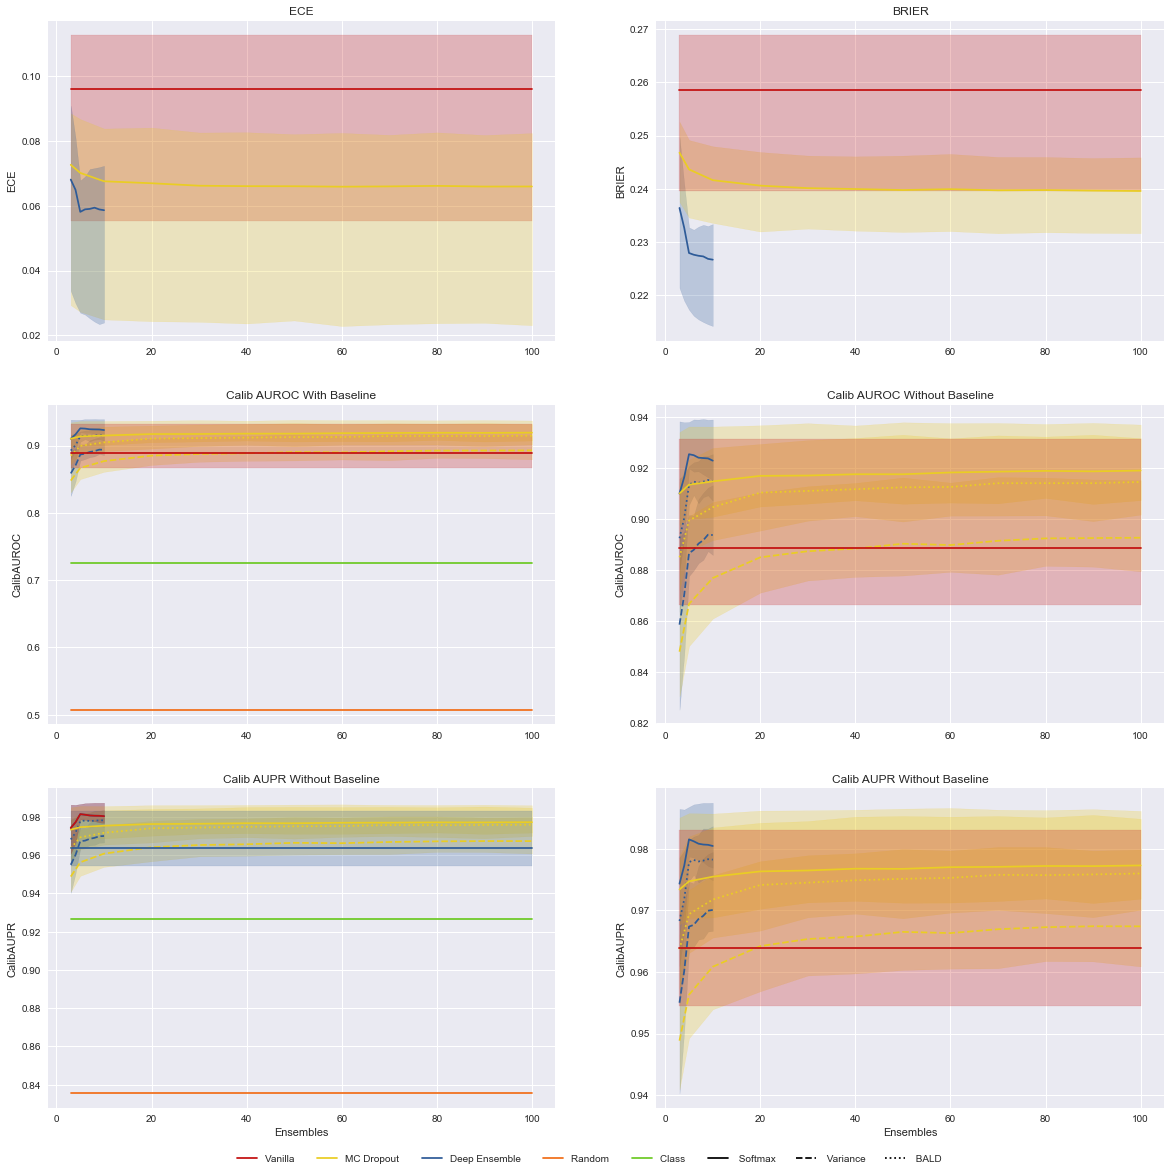

In [49]:
plot_metrics(Vanilla_df,MCDropout_df,DeepEnsemble_df,Random_Class_df,language="english")

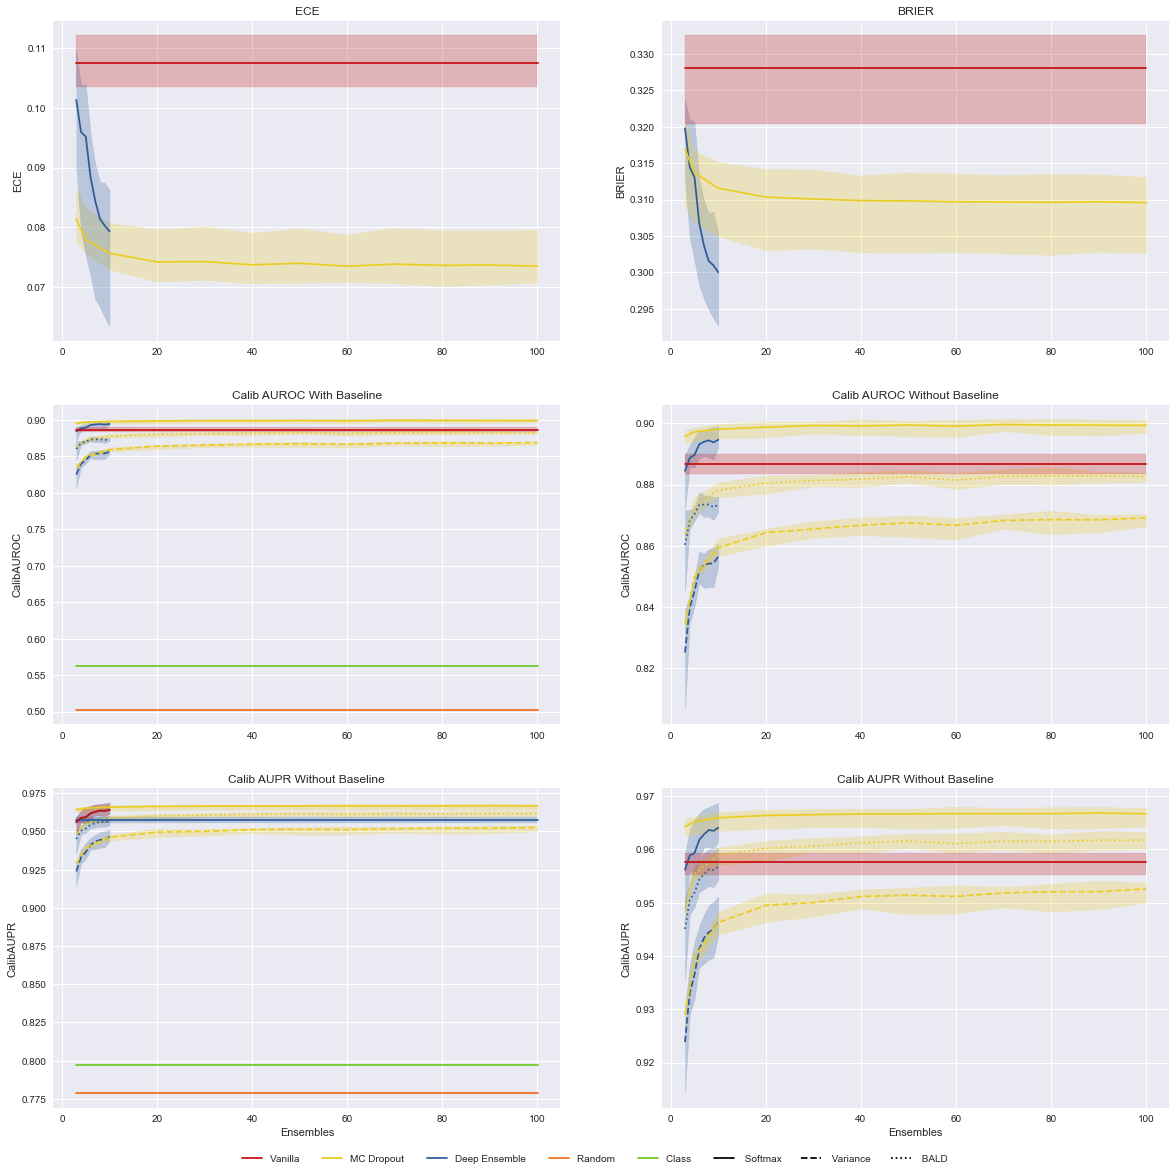

In [50]:
plot_metrics(Vanilla_df_german,MCDropout_df_german,DeepEnsemble_df_german,Random_Class_df_german, language="german")

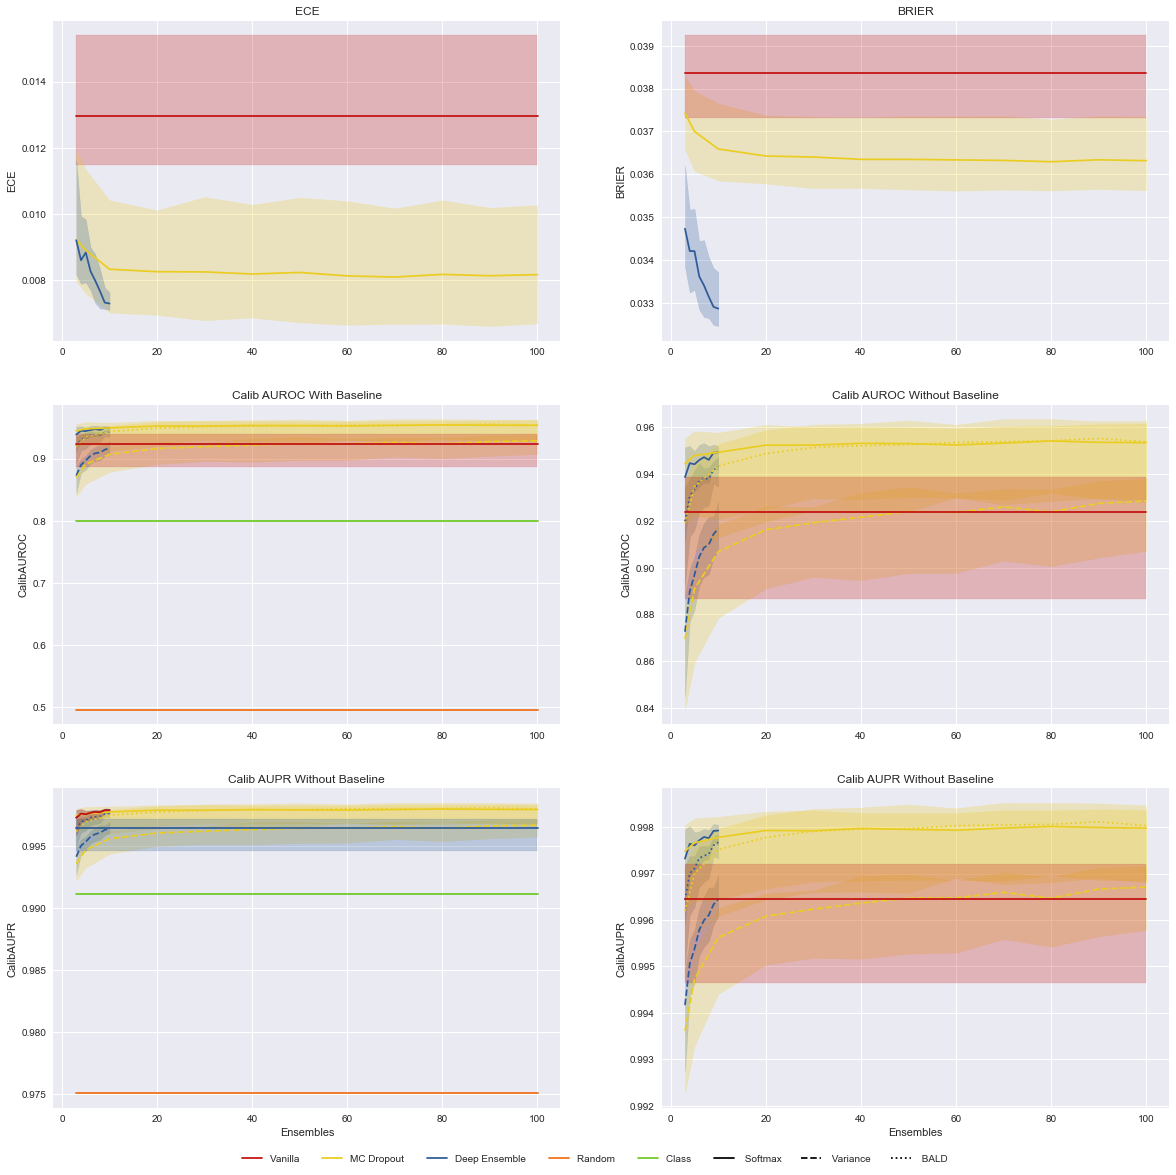

In [51]:
if in_domain:
    plot_metrics(Vanilla_df_romanian,MCDropout_df_romanian,DeepEnsemble_df_romanian,Random_Class_df_romanian, language="romanian")